In [1]:
import numpy as np
import os
from google.colab import drive
import pickle
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
from scipy.optimize import minimize
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Creating Environment

In [2]:

class GridWorld:
    def __init__(self, height, width, start, end, bad_regions, good_regions, good_region_reward, bad_region_reward, final_reward, sparsity):
        self.height = height
        self.width = width
        self.start = start
        self.end = end
        self.bad_regions = bad_regions
        self.good_regions = good_regions
        self.good_region_reward = good_region_reward
        self.bad_region_reward = bad_region_reward
        self.final_reward = final_reward
        self.sparsity = sparsity

        self.state_rewards = self.generate_state_rewards()
        self.reset()

    def reset(self):
        self.agent_position = self.start

    def generate_state_rewards(self):
        state_rewards = {}
        for x in range(self.width):
            for y in range(self.height):
                if (x, y) in self.good_regions:
                    state_rewards[(x, y)] = self.good_region_reward
                elif (x, y) in self.bad_regions:
                    state_rewards[(x, y)] = self.bad_region_reward
                elif (x,y) == self.start:
                  state_rewards[(x,y)] = 0
                elif (x,y) == self.end:
                  state_rewards[(x,y)] = self.final_reward
                else:
                    state_rewards[(x, y)] = 0.5 if np.random.random() < self.sparsity else 0.0
        return state_rewards

    def step(self, action):
        x, y = self.agent_position

        # Get the reward based on the current state and policy context
        reward = self.state_rewards.get((x, y), 0)

        if action == "up" and y < self.height - 1:
            y += 1
        elif action == "down" and y > 0:
            y -= 1
        elif action == "left" and x > 0:
            x -= 1
        elif action == "right" and x < self.width - 1:
            x += 1

        # Update agent position
        self.agent_position = (x, y)

        # Get the reward based on the current state and policy context
        reward = self.state_rewards.get(self.agent_position, 0)

        # # Update state_rewards for self.agent_position if needed
        # if self.agent_position in self.good_regions:
        #     self.state_rewards[self.agent_position] = self.good_region_reward
        # elif self.agent_position in self.bad_regions:
        #     self.state_rewards[self.agent_position] = self.bad_region_reward

        if self.agent_position in self.end:
            done = True
        else:
            done = False

        # Get the reward for the updated position and policy context
        updated_reward = self.state_rewards.get(self.agent_position, 0)

        # Check if the new position is the end state
        done = (self.agent_position == self.end)

        return self.agent_position, updated_reward, done



In [3]:
import numpy as np

class Agent:
    def __init__(self, epsilon=0.0):
        self.epsilon = epsilon

    def select_action(self, policy_func):
        if np.random.uniform() < self.epsilon:
            # Choose a random action
            action = np.random.choice(["up", "down", "left", "right"])
        else:
            # Use the provided policy function to get the best action
            action = policy_func()
        return action

# Define different policy functions outside the class

def random_policy():
    # Choose a random action
    return np.random.choice(["up", "down", "left", "right"])

# def behavior_policy(behav_policy):
#     action_probs = behav_policy
#     return np.random.choice(list(action_probs.keys()), p=list(action_probs.values()))

# def evaluation_policy(eval_policy):
#     action_probs = eval_policy
#     return np.random.choice(list(action_probs.keys()), p=list(action_probs.values()))

def run_policy(policy):
    action_probs = policy
    return np.random.choice(list(action_probs.keys()), p=list(action_probs.values()))


def manhattan_distance(pos1, pos2):
    # Compute the Manhattan distance between two positions
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}

# Generating Policy data

In [4]:
# Gridworld environment
height = 5
width  = 5
start = (0,0)
end = (4,4)

In [5]:

good_regions = [(3,3)]
bad_regions = [(1,1),(2,2)]
np.random.seed(42)

# Create an instance of the GridWorld class
gridworld = GridWorld(height, width, start, end, bad_regions, good_regions, 1, -2, 3, 0.5)

# Access the state_rewards dictionary
rewards = gridworld.state_rewards

# Print the rewards for each state
for state, reward in rewards.items():
    print(f"State: {state}, Reward: {reward}")


State: (0, 0), Reward: 0
State: (0, 1), Reward: 0.5
State: (0, 2), Reward: 0.0
State: (0, 3), Reward: 0.0
State: (0, 4), Reward: 0.0
State: (1, 0), Reward: 0.5
State: (1, 1), Reward: -2
State: (1, 2), Reward: 0.5
State: (1, 3), Reward: 0.5
State: (1, 4), Reward: 0.0
State: (2, 0), Reward: 0.0
State: (2, 1), Reward: 0.0
State: (2, 2), Reward: -2
State: (2, 3), Reward: 0.5
State: (2, 4), Reward: 0.0
State: (3, 0), Reward: 0.0
State: (3, 1), Reward: 0.5
State: (3, 2), Reward: 0.5
State: (3, 3), Reward: 1
State: (3, 4), Reward: 0.5
State: (4, 0), Reward: 0.5
State: (4, 1), Reward: 0.0
State: (4, 2), Reward: 0.5
State: (4, 3), Reward: 0.5
State: (4, 4), Reward: 3


In [6]:
def create_policy_set(env, policy_func, policy, num_episodes):
  # Create a list to store policies as trajectories
  policies = []

  # Run multiple episodes
  for episode in range(num_episodes):
      # Create a new Agent for each episode to generate a different policy

      agent = Agent(epsilon=0.0)

      # print(episode)
      # Run an episode
      env.reset()
      done = False
      trajectory = []  # Store the trajectory for the current episode
      cumulative_reward = 0.0  # Initialize cumulative reward
      while not done:
          state = env.agent_position  # Get the current state
          # print("State: ",state)
          action = agent.select_action(lambda: policy_func(policy))
          # print("Action: ",action)
          next_state, reward, done = env.step(action)
          # print("Next State: ", next_state)

          # Compute cumulative reward
          cumulative_reward += reward

          # Compute feature function values (manhattan distances)
          good_region_distances = [manhattan_distance(state, gr) for gr in env.good_regions]
          bad_region_distances = [manhattan_distance(state, br) for br in env.bad_regions]

          # Store the (state, action, reward, next_state) tuple in the trajectory
          trajectory.append((state, action, reward, next_state, cumulative_reward, good_region_distances, bad_region_distances))

      # Append the trajectory to the policies list
      policies.append(trajectory)

  return policies


In [7]:
# pi_b = create_policy_set(env, run_policy, behav, 200)

In [8]:
def calc_V_pi_e(evaluation_policies):
    all_timesteps = []
    gamma = 0.9
    for j in range(len(evaluation_policies)):
        Timestep_values = []
        for i in range(len(evaluation_policies[j])):
          # print(i)
          timestep = gamma ** (i) * evaluation_policies[j][i][2]
          Timestep_values.append(timestep)

        all_timesteps.append(Timestep_values)

    V_est = sum([sum(sublist) for sublist in all_timesteps])/len(evaluation_policies)
    return V_est

# Saving and Loading Data

In [9]:
def filename(env, behav_policy, eval_policy, num_episodes, train_split, sparsity):
    good_regions_str = "_".join([f"gr_{pos[0]}_{pos[1]}" for pos in env.good_regions])
    bad_regions_str = "_".join([f"br_{pos[0]}_{pos[1]}" for pos in env.bad_regions])

    behav_probs_str = "_".join([f"{prob:.2f}" for prob in behav_policy.values()])
    eval_probs_str = "_".join([f"{prob:.2f}" for prob in eval_policy.values()])

    file = f"pi_b_{behav_probs_str}_pi_e_{eval_probs_str}_{good_regions_str}_{env.good_region_reward}_{bad_regions_str}_{env.bad_region_reward}_trajectories_{num_episodes}_train_split_{train_split}_sparsity_{sparsity}.txt"
    return file

In [10]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [11]:

# Define the path to your desired folder
folder_path = '/content/drive/MyDrive/gridworld_same_reward_OPE_experiments'

# Change the working directory to the specified folder
os.chdir(folder_path)


In [12]:

def save_data_to_file(data, filename):
    with open(filename, 'wb') as file:
        pickle.dump(data, file)

def load_data_from_file(filename):
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return data


# OPE Calculations

## Importance Weights

In [13]:
def calculate_importance_weights(eval_policy, behav_policy, behavior_policies):
  all_weights = []
  for trajectory in behavior_policies:
    cum_ratio = 1
    cumul_weights = []
    for step in trajectory:
        ratio = eval_policy[step[1]]/behav_policy[step[1]]
        # print("Ratio:",ratio)
        cum_ratio *= ratio
        cumul_weights.append(cum_ratio)
        # print("Cumul:",cum_ratio)
    all_weights.append(cumul_weights)

  return all_weights

In [14]:

# def per_step_IS(scope_set, num_bootstraps):
#     all_timesteps = []
#     gamma = 0.9
#     # scope_set,_ = subset_policies(scope_set, phi_trajectories)
#     scope_weights = calculate_importance_weights(eval_policy, behav_policy, scope_set)
#     for j in range(len(scope_weights)):
#         Timestep_values = []
#         for i in range(len(scope_weights[j]) - 1):
#             timestep = gamma ** (i) * scope_weights[j][i] * scope_set[j][i][2]
#             Timestep_values.append(timestep)

#         all_timesteps.append(Timestep_values)

#     V_per_traj = [sum(sublist) for sublist in all_timesteps]

#     # seed_value = 42
#     # np.random.seed(seed_value)

#     num_trajectories_to_sample = max(1, len(V_per_traj))

#     seed_value = 0
#     np.random.seed(seed_value)

#     bootstrap_samples = [np.random.choice(V_per_traj, size=num_trajectories_to_sample, replace=True)
#                          for _ in range(num_bootstraps)]

#     V_per_sample = [sum(sample) / len(scope_set) for sample in bootstrap_samples]
#     V_per_sample = np.array(V_per_sample)

#     std_deviation = np.std(V_per_sample)
#     quartiles = np.percentile(V_per_sample, [0,25, 50, 75,100])
#     max_value = np.max(V_per_sample)
#     min_value = np.min(V_per_sample)
#     mean = np.mean(V_per_sample)

#     return {
#         'std_deviation': std_deviation,
#         'quartiles': quartiles,
#         'max_value': max_value,
#         'min_value': min_value,
#         'mean': mean
#     }


## IS

In [15]:

def per_step_IS1(scope_set, num_bootstraps):
    all_timesteps = []
    gamma = 0.9
    # scope_set,_ = subset_policies(scope_set, phi_trajectories)
    scope_weights = calculate_importance_weights(eval_policy, behav_policy, scope_set)
    for j in range(len(scope_weights)):
        Timestep_values = []
        for i in range(len(scope_weights[j]) - 1):
            timestep = gamma ** (i) * scope_weights[j][i] * scope_set[j][i][2]
            Timestep_values.append(timestep)

        all_timesteps.append(Timestep_values)

    V_per_traj = [sum(sublist) for sublist in all_timesteps]


    num_trajectories_to_sample = max(1, len(V_per_traj))


    V_per_traj = [sum(sublist) for sublist in all_timesteps]
    num_trajectories_to_sample = max(1, len(V_per_traj))

    std_devs = []
    means = []

    seed_value = 0
    np.random.seed(seed_value)

    for i in range(5):

      bootstrap_samples = [np.random.choice(V_per_traj, size=num_trajectories_to_sample, replace=True)
                            for _ in range(num_bootstraps)]

      V_per_sample = [sum(sample)/len(scope_set) for sample in bootstrap_samples]
      V_per_sample = np.array(V_per_sample)

      std_deviation = np.std(V_per_sample)
      quartiles = np.percentile(V_per_sample, [0,25, 50, 75,100])
      max_value = np.max(V_per_sample)
      min_value = np.min(V_per_sample)
      mean = np.mean(V_per_sample)

      std_devs.append(std_deviation)
      means.append(mean)

    return {
        'std_devs_list': std_devs,
        'mean_list': means
    }



In [16]:

# def SCOPE(scope_policies, beta, num_bootstraps):
#     all_timesteps = []
#     gamma = 0.9
#     # scope_policies,_ = subset_policies(scope_policies, phi_trajectories)
#     scope_weights = calculate_importance_weights(eval_policy, behav_policy, scope_policies)
#     for j in range(len(scope_weights)):
#         Timestep_values = []
#         for i in range(len(scope_weights[j]) - 1):
#             features = scope_policies[j][i][5] + scope_policies[j][i][6]
#             features_next = scope_policies[j][i + 1][5] + scope_policies[j][i + 1][6]
#             timestep = gamma ** (i) * scope_weights[j][i] * (scope_policies[j][i][2] + gamma * phi(features_next, beta) - phi(features, beta))
#             Timestep_values.append(timestep)

#         all_timesteps.append(Timestep_values)


#     V_per_traj = [sum(sublist) for sublist in all_timesteps]


#     num_trajectories_to_sample = max(1, len(V_per_traj))

#     bootstrap_samples = [np.random.choice(V_per_traj, size=num_trajectories_to_sample, replace=True)
#                          for _ in range(num_bootstraps)]

#     V_per_sample = [sum(sample)/len(scope_policies) for sample in bootstrap_samples]
#     V_per_sample = np.array(V_per_sample)

#     std_deviation = np.std(V_per_sample)
#     quartiles = np.percentile(V_per_sample, [0,25, 50, 75,100])
#     max_value = np.max(V_per_sample)
#     min_value = np.min(V_per_sample)
#     mean = np.mean(V_per_sample)

#     return {
#         'std_deviation': std_deviation,
#         'quartiles': quartiles,
#         'max_value': max_value,
#         'min_value': min_value,
#         'mean': mean
#     }


## SCOPE

In [17]:

def SCOPE1(scope_policies, beta, num_bootstraps):
    all_timesteps = []
    gamma = 0.9
    # scope_policies,_ = subset_policies(scope_policies, phi_trajectories)
    scope_weights = calculate_importance_weights(eval_policy, behav_policy, scope_policies)
    for j in range(len(scope_weights)):
        Timestep_values = []
        for i in range(len(scope_weights[j]) - 1):
            features = scope_policies[j][i][5] + scope_policies[j][i][6]
            features_next = scope_policies[j][i + 1][5] + scope_policies[j][i + 1][6]
            timestep = gamma ** (i) * scope_weights[j][i] * (scope_policies[j][i][2] + gamma * phi(features_next, beta) - phi(features, beta))
            Timestep_values.append(timestep)

        all_timesteps.append(Timestep_values)


    V_per_traj = [sum(sublist) for sublist in all_timesteps]
    num_trajectories_to_sample = max(1, len(V_per_traj))

    std_devs = []
    means = []
    seed_value = 0
    np.random.seed(seed_value)
    for i in range(5):

      bootstrap_samples = [np.random.choice(V_per_traj, size=num_trajectories_to_sample, replace=True)
                            for _ in range(num_bootstraps)]

      V_per_sample = [sum(sample)/len(scope_policies) for sample in bootstrap_samples]
      V_per_sample = np.array(V_per_sample)

      std_deviation = np.std(V_per_sample)
      quartiles = np.percentile(V_per_sample, [0,25, 50, 75,100])
      max_value = np.max(V_per_sample)
      min_value = np.min(V_per_sample)
      mean = np.mean(V_per_sample)

      std_devs.append(std_deviation)
      means.append(mean)

    return {
        'std_devs_list': std_devs,
        'mean_list': means
    }


# Variance Preparation and Calculation

## Phi functions

In [18]:
def phi(features, beta):
  features = np.array(features)
  beta = np.array(beta)
  phi_linear = np.dot(beta,features)
  return phi_linear


In [19]:
def phi2(features, beta):
    features = np.array(features)
    beta = np.array(beta)

    # Calculate the matrix multiplication and then element-wise multiplication
    phi_quadratic = np.dot(features, np.dot(beta, features.T))

    return phi_quadratic

## Variance Terms

In [20]:
import random
# gamma = 0.9
# beta = [random.random() for _ in range(3)]
def variance_terms(policy_set,gamma, beta):
  all_weights = calculate_importance_weights(eval_policy, behav_policy, policy_set)
  y_w_r_all = 0
  r_all = 0
  f_a = 0
  for n in range(len(policy_set)):
    y_w_r = 0
    r = 0
    for t in range(len(policy_set[n])-1):
      features = policy_set[n][t][5]+policy_set[n][t][6]
      y_w_r += gamma**(t)*all_weights[n][t]*policy_set[n][t][2]
      if t>0:
        r += phi(features, beta)*(all_weights[n][t-1]-all_weights[n][t])
    features_last = policy_set[n][-1][5] + policy_set[n][-1][6]
    features_first = policy_set[n][0][5]+policy_set[n][0][6]
    y_w_r_all += y_w_r
    f_a +=  gamma**(len(policy_set[n]))*all_weights[n][-1]*phi(features_last,beta) - phi(features_first, beta)
    r_all += r

  IS = y_w_r_all/len(policy_set)
  R = r_all/len(policy_set)
  F = f_a/len(policy_set)
  return IS, R, F


In [21]:

def subset_policies(policies, percent_to_estimate_phi):
    seed_value = 0
    np.random.seed(seed_value)
    num_policies = len(policies)
    num_policies_to_estimate_phi = int(num_policies * percent_to_estimate_phi)

    policies_for_scope = policies[num_policies_to_estimate_phi:]
    policies_for_phi = policies[:num_policies_to_estimate_phi]

    return policies_for_scope, policies_for_phi


In [22]:
def calc_variance(phi_policies, gamma, beta, num_bootstrap_samples):
  # Set the seed value (you can use any integer value)
  seed_value = 0
  np.random.seed(seed_value)
  num_trajectories_to_sample = max(1, len(phi_policies))

  bootstrap_samples = [np.random.choice(phi_policies, size=num_trajectories_to_sample, replace=True)
                         for _ in range(num_bootstrap_samples)]
  IS_all = []
  R_all = []
  F_all = []

  for pol in bootstrap_samples:
    IS, R, F = variance_terms(pol,0.9,beta)
    IS_all.append(IS)
    R_all.append(R)
    F_all.append(F)
  IS_sq = np.mean([num**2 for num in IS_all])
  IS_R_F = 2*np.mean([IS_all[i]*(R_all[i]+F_all[i]) for i in range(len(IS_all))])
  R_sq = np.mean([num**2 for num in R_all])
  IS_sq_all = (np.mean(IS_all))**2
  IS_r_t_f = 2*np.mean(IS_all)*np.mean([R_all[i]+F_all[i] for i in range(len(R_all))])
  R_sq_all = (np.mean(R_all))**2

  variance_scope = IS_sq + IS_R_F + R_sq - IS_sq_all - IS_r_t_f - R_sq_all
  variance_is = IS_sq - IS_sq_all
  return variance_scope, variance_is

In [23]:
def calc_variance1(phi_policies, gamma, beta, num_bootstrap_samples):
  # Set the seed value (you can use any integer value)
  # seed_value = 42
  # np.random.seed(seed_value)
  num_trajectories_to_sample = max(1, len(phi_policies))

  bootstrap_samples = [np.random.choice(phi_policies, size=num_trajectories_to_sample, replace=True)
                         for _ in range(num_bootstrap_samples)]
  IS_all = []
  R_all = []
  F_all = []

  for pol in bootstrap_samples:
    IS, R, F = variance_terms(pol,0.9,beta)
    IS_all.append(IS)
    R_all.append(R)
    F_all.append(F)
  IS_sq = np.mean([num**2 for num in IS_all])
  IS_R_F = 2*np.mean([IS_all[i]*(R_all[i]+F_all[i]) for i in range(len(IS_all))])
  R_sq = np.mean([num**2 for num in R_all])
  IS_sq_all = (np.mean(IS_all))**2
  IS_r_t_f = 2*np.mean(IS_all)*np.mean([R_all[i]+F_all[i] for i in range(len(R_all))])
  R_sq_all = (np.mean(R_all))**2

  variance_scope = IS_sq + IS_R_F + R_sq - IS_sq_all - IS_r_t_f - R_sq_all
  variance_is = IS_sq - IS_sq_all
  return variance_scope, variance_is

An example of an initial guess of phi can be seen below, as you can see the SCOPE variance is not ideal.

In [24]:
# scope_set, phi_set = subset_policies(behavior_policies, 0.3)
# variance_scope, variance_is = calc_variance(phi_set,0.9,[-0.1,.1,.1], 100, 0.3)
# print("Var SCOPE: ",variance_scope)
# print("Var IS: ",variance_is)
# print("Percent change in variance: ",((variance_scope-variance_is)/variance_is)*100)

# Optimization

Here we aim to optimize beta to minimize SCOPE variance.

In [25]:
# Define the objective function to minimize variance_scope
def objective_function(beta, phi_set):
    # scope_set, phi_set = subset_policies(phi_set, phi_trajectories)
    variance_scope, variance_is = calc_variance(phi_set, 0.9, beta, 100)
    return variance_scope

# Set the initial values of beta
# initial_beta = np.array([ 0.2610704,   0.30396575, -0.43850237])


def optimize_variance_scope(initial_beta, phi_set, phi_trajectories):
    # Lists to store beta and variance_scope values at each iteration
    all_betas = []
    all_variance_scopes = []

    # Callback function to record beta and variance_scope values at each iteration
    def callback_function(beta):
        all_betas.append(beta.copy())
        variance_scope = objective_function(beta, phi_set)
        all_variance_scopes.append(variance_scope)
        print("Iteration:", len(all_betas))
        print("Beta:", beta)
        print("Variance Scope:", variance_scope)
        print("----------")

    # Run the optimization with the callback
    result = minimize(
        objective_function,
        initial_beta,
        args=(phi_set),
        method='L-BFGS-B',
        callback=callback_function
    )

    # Extract the optimal beta values
    optimal_beta = result.x

    return optimal_beta


# Playground to run individual trajectories

In [26]:
# env = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [], 1, -2, 3, 0.1)
# behavior_policies = create_policy_set(env, run_policy,behav_policy, 400)
# initial_beta = [random.uniform(-0.5, 0.5) for _ in range(len(env.good_regions + env.bad_regions))]
# scope_set, phi_set = subset_policies(behavior_policies, 0.3)
# optimal_beta = optimize_variance_scope(initial_beta, phi_set, 0.3)
# variance_scope, variance_is = calc_variance(phi_set,0.9,optimal_beta, 500)
# print("Var SCOPE_phi: ",variance_scope)
# print("Var IS_phi: ",variance_is)
# print("Percent change in variance: ",((variance_scope-variance_is)/variance_is)*100)

In [27]:
# scope_results = SCOPE(scope_set,optimal_beta,500)
# IS_results = per_step_IS(scope_set,500)
# print("SCOPE results: ", scope_results)
# print("IS results: ", IS_results)
# evaluation_policies = create_policy_set(env, run_policy,eval_policy, 1000)
# true_evaluation = calc_V_pi_e(evaluation_policies)
# print("true eval: ", true_evaluation)

# Modify Data

In [28]:
def modify_data(env, num_episodes, behav_policy, eval_policy, phi_traj, sparsity):
  file = filename(env, behav_policy, eval_policy, num_episodes, phi_traj, sparsity)
  # Check if the file already exists
  if os.path.exists(file):
    loaded_data = load_data_from_file(file)
    behavior_policies = loaded_data['policy_set']
    scope_set, phi_set = subset_policies(behavior_policies, phi_traj)
    beta = loaded_data['optimal_beta']
    # scope_results = loaded_data['scope_results']
    scope_results_new = SCOPE1(scope_set,beta,500)
    IS_results_new = per_step_IS1(scope_set,500)
    loaded_data['scope_results'] = scope_results_new
    loaded_data['IS_results'] = IS_results_new
    true_evals = []
    for i in range(5):
      evaluation_policies = create_policy_set(env, run_policy,eval_policy, 1000)
      true_evaluation = calc_V_pi_e(evaluation_policies)
      true_evals.append(true_evaluation)
    loaded_data['True Evaluations'] = true_evals
    save_data_to_file(loaded_data, file)
    print("modifying... ")
    print("scope new: ",scope_results_new)
    print("IS new: ", IS_results_new)



In [29]:
# def run_experiment(env, num_episodes, behav_policy, eval_policy, phi_traj, sparsity):
#   file = filename(env, behav_policy, eval_policy, num_episodes, phi_traj, sparsity)
#   # Check if the file already exists
#   if os.path.exists(file):
#     loaded_data = load_data_from_file(file)
#     # modify_data(env, num_episodes, behav_policy, eval_policy, phi_traj, sparsity)
#     return loaded_data


#   behavior_policies = create_policy_set(env, run_policy,behav_policy, num_episodes)
#   initial_beta = [random.uniform(-0.5, 0.5) for _ in range(len(env.good_regions + env.bad_regions))]
#   scope_set, phi_set = subset_policies(behavior_policies, phi_traj)
#   optimal_beta = optimize_variance_scope(initial_beta, phi_set, phi_traj)
#   variance_scope, variance_is = calc_variance(phi_set,0.9,optimal_beta, 500)
#   print("Var SCOPE_phi: ",variance_scope)
#   print("Var IS_phi: ",variance_is)
#   print("Percent change in variance: ",((variance_scope-variance_is)/variance_is)*100)
#   scope_results = SCOPE(scope_set,optimal_beta,500)
#   IS_results = per_step_IS(scope_set,500)
#   print("SCOPE results: ", scope_results)
#   print("IS results: ", IS_results)
#   true_evals = []
#   for i in range(5):
#     evaluation_policies = create_policy_set(env, run_policy,eval_policy, 1000)
#     true_evaluation = calc_V_pi_e(evaluation_policies)
#     true_evals.append(true_evaluation)
#   print("true eval: ", np.mean(np.array(true_evals)))
#   data_to_save = {
#     'policy_set': behavior_policies,
#     'optimal_beta': optimal_beta,
#     'variance_scope_train': variance_scope,
#     'variance_IS_train': variance_is,
#     'scope_results': scope_results,
#     'IS_results': IS_results,
#     'True Evaluations': true_evals
#   }
#   save_data_to_file(data_to_save, file)

#   return data_to_save



# Experiment Function

In [39]:
def run_experiment1(env, num_episodes, behav_policy, eval_policy, phi_traj, sparsity):
  file = filename(env, behav_policy, eval_policy, num_episodes, phi_traj, sparsity)
  # Check if the file already exists
  if os.path.exists(file):
    loaded_data = load_data_from_file(file)
    # loaded_data = modify_data(env, num_episodes, behav_policy, eval_policy, phi_traj, sparsity)
    return loaded_data

  behavior_policies = create_policy_set(env, run_policy,behav_policy, num_episodes)
  initial_beta = [random.uniform(-0.5, 0.5) for _ in range(len(env.good_regions + env.bad_regions))]
  scope_set, phi_set = subset_policies(behavior_policies, phi_traj)
  optimal_beta = optimize_variance_scope(initial_beta, phi_set, phi_traj)
  variance_scope, variance_is = calc_variance(phi_set,0.9,optimal_beta, 500)
  print("Var SCOPE_phi: ",variance_scope)
  print("Var IS_phi: ",variance_is)
  print("Percent change in variance: ",((variance_scope-variance_is)/variance_is)*100)
  scope_results = SCOPE1(scope_set,optimal_beta,500)
  IS_results = per_step_IS1(scope_set,500)
  print("SCOPE results: ", scope_results)
  print("IS results: ", IS_results)
  true_evals = []
  for i in range(5):
    evaluation_policies = create_policy_set(env, run_policy,eval_policy, 1000)
    true_evaluation = calc_V_pi_e(evaluation_policies)
    true_evals.append(true_evaluation)
  print("true eval: ", np.mean(np.array(true_evals)))
  data_to_save = {
    'policy_set': behavior_policies,
    'optimal_beta': optimal_beta,
    'variance_scope_train': variance_scope,
    'variance_IS_train': variance_is,
    'scope_results': scope_results,
    'IS_results': IS_results,
    'True Evaluations': true_evals
  }
  save_data_to_file(data_to_save, file)

  return data_to_save



In [31]:
def run_loaded(env, num_episodes, behav_policy, eval_policy, phi_traj, sparsity):
  file = filename(env, behav_policy, eval_policy, num_episodes, phi_traj, sparsity)
  # Check if the file already exists
  if os.path.exists(file):
    loaded_data = load_data_from_file(file)
    # loaded_data = modify_data(env, num_episodes, behav_policy, eval_policy, phi_traj, sparsity)
    return loaded_data

In [32]:
# def plot_rewards_over_trajectories(env, num_trajectories, behav_policy, eval_policy, phi_traj, sparsity):
#     combined_scope = []
#     combined_is = []

#     for i in range(len(num_trajectories)):
#         results = run_experiment(env, num_trajectories[i], behav_policy, eval_policy, phi_traj, sparsity)
#         if num_trajectories[i] == 200:
#             true_val = results['True Evaluations']

#         scope_results = results['scope_results']
#         is_results = results['IS_results']

#         quartiles_scope = scope_results['quartiles']
#         quartiles_is = is_results['quartiles']

#         combined_scope.append(quartiles_scope)
#         combined_is.append(quartiles_is)


#     # Transpose the quartiles data for compatibility with boxplot
#     combined_scope = np.array(combined_scope).T
#     combined_is = np.array(combined_is).T

#     # Create box and whisker plots for both SCOPE and IS data on the same plot
#     plt.boxplot(combined_scope, positions=np.array(range(len(num_trajectories))) * 2 - 0.4, labels=num_trajectories, widths=0.4, patch_artist=True, boxprops=dict(facecolor='blue'), vert=True)
#     plt.boxplot(combined_is, positions=np.array(range(len(num_trajectories))) * 2 + 0.4, labels=num_trajectories, widths=0.4, patch_artist=True, boxprops=dict(facecolor='orange'), vert=True)

#     plt.xlabel('Number of Trajectories')
#     plt.ylabel('Value Estimate')
#     plt.title('SCOPE and stepIS Box and Whisker Plots vs. Number of Trajectories')

#     # Add horizontal line for true_val
#     plt.axhline(y=true_val, color='green', linestyle='--', label='True Value')

#     # Create custom legend handles and labels
#     custom_legend_handles = [
#         Line2D([0], [0], color='blue', marker='s', markersize=10, label='SCOPE'),
#         Line2D([0], [0], color='orange', marker='s', markersize=10, label='stepIS'),
#         Line2D([0], [0], color='green', linestyle='--', label='True Value')
#     ]

#     plt.legend(handles=custom_legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

#     plt.grid(True)
#     plt.tight_layout()  # Ensures proper spacing and avoids clipping
#     plt.show()



# Plotting Functions

In [38]:
def plot_rewards_over_trajectories1(env, num_trajectories, behav_policy, eval_policy, phi_traj, sparsity):
    # combined_scope = []
    # combined_is = []

    combined_scope_means = []
    combined_scope_std_devs = []
    combined_is_means = []
    combined_is_std_devs = []

    combined_scope_vars = []
    combined_scope_var_std_devs = []
    combined_is_vars = []
    combined_is_var_std_devs = []

    combined_scope_bias = []
    combined_scope_bias_std_devs = []
    combined_is_bias = []
    combined_is_bias_std_devs = []

    combined_scope_mse = []
    combined_is_mse = []


    for i in range(len(num_trajectories)):
        results = run_loaded(env, num_trajectories[i], behav_policy, eval_policy, phi_traj, sparsity)
        print("Trajectories: ", num_trajectories[i])
        # if num_trajectories[i] == 200:
        true_val = results['True Evaluations']
        print("True Val: ",true_val)

        optimal_beta = results['optimal_beta']
        print("Optimal Beta: ", optimal_beta)

        true_value = np.mean(np.array(true_val))
        scope_results = results['scope_results']
        is_results = results['IS_results']

        print('SCOPE Results: ', scope_results)
        print('IS Results: ', is_results)

        sd_scope = scope_results['std_devs_list']
        sd_is = is_results['std_devs_list']

        means_scope = scope_results['mean_list']
        means_is = is_results['mean_list']

        combined_scope_means.append(np.mean(np.array(means_scope)))
        combined_scope_std_devs.append(np.std(np.array(means_scope)))
        combined_is_means.append(np.mean(np.array(means_is)))
        combined_is_std_devs.append(np.std(np.array(means_is)))

        combined_scope_vars.append(np.mean(np.array(sd_scope)**2))
        combined_scope_var_std_devs.append(np.std(np.array(sd_scope)**2))
        combined_is_vars.append(np.mean(np.array(sd_is)**2))
        combined_is_var_std_devs.append(np.std(np.array(sd_is)**2))


        combined_scope_bias.append(np.mean(np.array(means_scope)-np.array(true_val)))
        combined_scope_bias_std_devs.append(np.std(np.array(means_scope)-np.array(true_val)))
        combined_is_bias.append(np.mean(np.array(means_is)-np.array(true_val)))
        combined_is_bias_std_devs.append(np.std(np.array(means_is)-np.array(true_val)))

        mse_scope = np.mean(np.array(sd_scope)**2) + (np.mean(np.array(means_scope)-np.array(true_val)))**2
        # print("mse_scope: ", mse_scope)
        combined_scope_mse.append(mse_scope)
        combined_is_mse.append(np.mean(np.array(sd_is)**2) + (np.mean(np.array(means_is)-np.array(true_val)))**2)

    plt.figure()
    # Plotting
    plt.errorbar(num_trajectories, combined_scope_vars, yerr=combined_scope_var_std_devs, fmt='bs', label='SCOPE')
    plt.errorbar(num_trajectories, combined_is_vars, yerr=combined_is_var_std_devs, fmt='ko', label='stepIS')

    plt.xlabel('Number of Trajectories')
    plt.ylabel('Variance')
    plt.title('SCOPE and stepIS Variance Plots vs. Number of Trajectories')
    custom_legend_handles = [
        Line2D([0], [0], color='blue', marker='s', markersize=10, label='SCOPE'),
        Line2D([0], [0], color='black', marker='o', markersize=10, label='stepIS')
    ]

    plt.legend(handles=custom_legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(True)
    plt.tight_layout()  # Ensures proper spacing and avoids clipping
    plt.show()




    plt.figure()

    plt.figure()
    # Plotting
    plt.errorbar(num_trajectories, combined_scope_bias, yerr=combined_scope_bias_std_devs, fmt='bs', label='SCOPE')
    plt.errorbar(num_trajectories, combined_is_bias, yerr=combined_is_bias_std_devs, fmt='ko', label='stepIS')

    plt.xlabel('Number of Trajectories')
    plt.ylabel('Bias')
    plt.title('SCOPE and stepIS Bias Plots vs. Number of Trajectories')
    custom_legend_handles = [
        Line2D([0], [0], color='blue', marker='s', markersize=10, label='SCOPE'),
        Line2D([0], [0], color='black', marker='o', markersize=10, label='stepIS')
    ]

    plt.legend(handles=custom_legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(True)
    plt.tight_layout()  # Ensures proper spacing and avoids clipping
    plt.show()



    plt.figure()

    # Plotting
    plt.errorbar(num_trajectories, combined_scope_means, yerr=combined_scope_std_devs, fmt='bs', label='SCOPE')
    plt.errorbar(num_trajectories, combined_is_means, yerr=combined_is_std_devs, fmt='ko', label='stepIS')

    plt.xlabel('Number of Trajectories')
    plt.ylabel('Value Estimate')
    plt.title('SCOPE and stepIS Value Estimate Plots vs. Number of Trajectories')

    # Add horizontal line for true_val
    plt.axhline(y=true_value, color='green', linestyle='--', label='True Value')

    # Create custom legend handles and labels
    custom_legend_handles = [
        Line2D([0], [0], color='blue', marker='s', markersize=10, label='SCOPE'),
        Line2D([0], [0], color='black', marker='o', markersize=10, label='stepIS'),
        Line2D([0], [0], color='green', linestyle='--', label='True Value')
    ]

    plt.legend(handles=custom_legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(True)
    plt.tight_layout()  # Ensures proper spacing and avoids clipping
    plt.show()

    plt.figure()

    # Plotting
    plt.plot(num_trajectories, combined_scope_mse, color='blue', marker='s', label='SCOPE')
    plt.plot(num_trajectories, combined_is_mse, color='black', marker='o', label='stepIS')


    plt.xlabel('Number of Trajectories')
    plt.ylabel('MSE')
    plt.title('SCOPE and stepIS MSE Plots vs. Number of Trajectories')


    # Create custom legend handles and labels
    custom_legend_handles = [
        Line2D([0], [0], color='blue', marker='s', markersize=10, label='SCOPE'),
        Line2D([0], [0], color='black', marker='o', markersize=10, label='stepIS')
    ]

    plt.legend(handles=custom_legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(True)
    plt.tight_layout()  # Ensures proper spacing and avoids clipping
    plt.show()




In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_mse_over_trajectories(env, num_trajectories, behav_policy, eval_policy, phi_traj, sparsity):
    combined_scope = []
    combined_is = []
    bias_scope = []
    bias_is = []
    variance_scope = []
    variance_is = []

    for i in range(len(num_trajectories)):
        results = run_experiment(env, num_trajectories[i], behav_policy, eval_policy, phi_traj, sparsity)
        if num_trajectories[i] == 200:
            true_val = results['True Evaluation']

        scope_results = results['scope_results']
        is_results = results['IS_results']

        scope_std_dev = scope_results['std_deviation']
        scope_mean = scope_results['mean']
        is_std_dev = is_results['std_deviation']
        is_mean = is_results['mean']

        scope_bias = true_val - scope_mean
        is_bias = true_val - is_mean

        scope_mse = scope_std_dev ** 2 + (scope_bias) ** 2
        is_mse = is_std_dev ** 2 + (is_bias) ** 2

        bias_scope.append(scope_bias)
        bias_is.append(is_bias)

        variance_scope.append(scope_std_dev ** 2)
        variance_is.append(is_std_dev ** 2)

        combined_scope.append(scope_mse)
        combined_is.append(is_mse)
    plt.figure()
    plt.plot(num_trajectories, bias_scope, marker='o', label=f'SCOPE')
    plt.plot(num_trajectories, bias_is, marker='x', label=f'stepIS')
    plt.title('SCOPE and stepIS Bias vs. Number of Trajectories')

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(num_trajectories, variance_scope, marker='o', label=f'SCOPE')
    plt.plot(num_trajectories, variance_is, marker='x', label=f'stepIS')
    plt.title('SCOPE and stepIS Variance vs. Number of Trajectories')

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure()

    plt.plot(num_trajectories, combined_scope, marker='o', label=f'SCOPE')
    plt.plot(num_trajectories, combined_is, marker='x', label=f'stepIS')

    plt.xlabel('Number of Trajectories')
    plt.ylabel('MSE')
    plt.title('SCOPE and stepIS MSE vs. Number of Trajectories')

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Compare Trajectories

In [37]:
def compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, phi_traj, sparsity):
  for i in num_trajectories:
    # print("Number of trajectories: ",i)
    run_experiment1(env,i ,behav_policy, eval_policy, phi_traj, sparsity)

  plot_rewards_over_trajectories1(env,num_trajectories,behav_policy, eval_policy, phi_traj,sparsity)
  # plot_mse_over_trajectories(env,num_trajectories,behav_policy, eval_policy, phi_traj,sparsity)

In [36]:
np.random.seed(42)
# Gridworld environment
height = 5
width  = 5
start = (0,0)
end = (4,4)

## Dense 2 bad regions, 1 good

In [40]:
np.random.seed(42)
# Gridworld environment
height = 5
width  = 5
start = (0,0)
end = (4,4)

Trajectories:  200
True Val:  [2.1206663403601893, 2.100262770466957, 2.0816665426606016, 2.201089404252533, 2.024700710184693]
Optimal Beta:  [ 0.48445545 -0.07920478 -0.38562516]
SCOPE Results:  {'std_devs_list': [0.2527938365057217, 0.2762517409476893, 0.27378870417895756, 0.2627738033904239, 0.26423470362978346], 'mean_list': [-0.23555627792607417, -0.19778891934279896, -0.2181032064292636, -0.20498854982745457, -0.2524476895538243]}
IS Results:  {'std_devs_list': [0.29401704217910546, 0.3148628055673071, 0.30746223855902916, 0.3126577034501254, 0.3120812012065544], 'mean_list': [1.1828937194665983, 1.1958437312261967, 1.1670883296987398, 1.191972967244261, 1.1552040912080452]}
Trajectories:  400
True Val:  [1.9971733557713471, 2.2731138088129446, 2.0311913775677235, 2.1117743892087164, 2.1999346612245545]
Optimal Beta:  [ 0.18633415  0.12729159 -0.40974519]
SCOPE Results:  {'std_devs_list': [0.37586055633268134, 0.39884996165335984, 0.3729738333433056, 0.40483394426053454, 0.39692

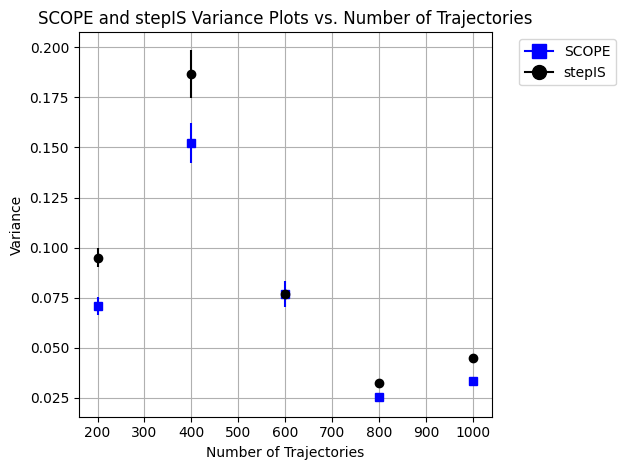

<Figure size 640x480 with 0 Axes>

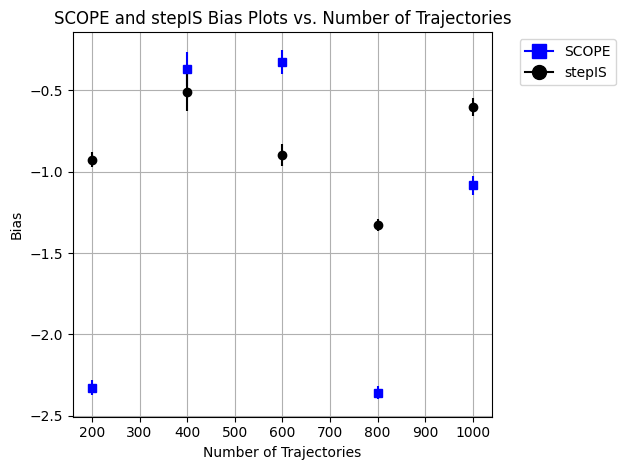

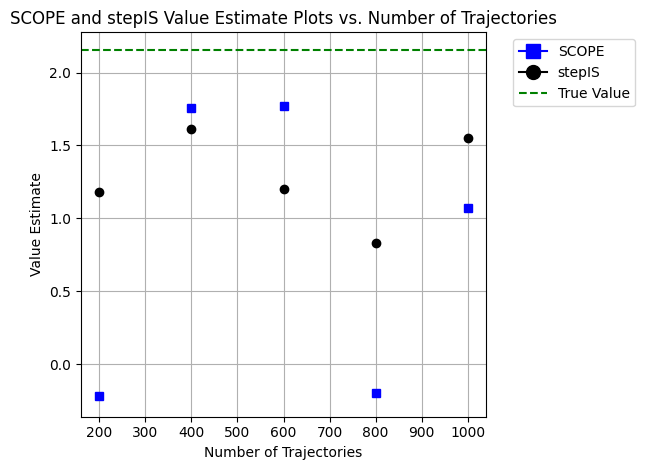

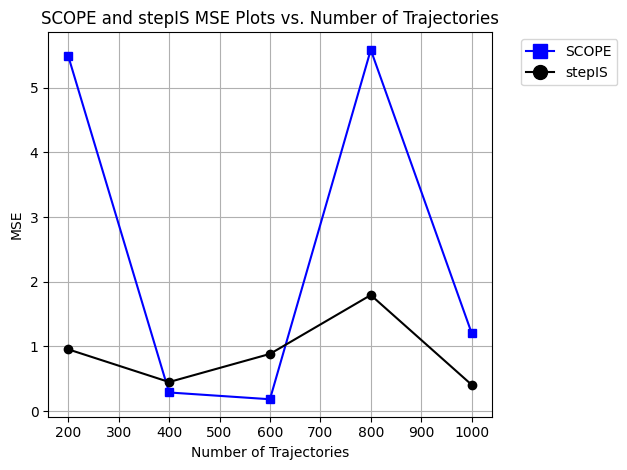

In [41]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [(3,3)], 1, -2, 3, 0.9)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.9 )

## Sparse 2 bad, 1 good

Trajectories:  200
True Val:  [-0.6740153116787657, -0.5836558954755371, -0.5642188555563586, -0.5684935369724002, -0.5869047409377887]
Optimal Beta:  [ 0.02765055  0.01793988 -0.12251193]
SCOPE Results:  {'std_devs_list': [0.2378392961829427, 0.25488771751137995, 0.24404808100110092, 0.2522646328419157, 0.2424538451229671], 'mean_list': [-0.9653276520649895, -0.9599319437616828, -0.9643338601998183, -0.9606068480005134, -0.9749944298691381]}
IS Results:  {'std_devs_list': [0.24727931362402777, 0.2642024979458262, 0.2531821089782617, 0.2622730174522364, 0.25030680299531605], 'mean_list': [-1.2073911211270723, -1.2005412100067359, -1.2048982970187527, -1.2028090656471393, -1.2175869303463858]}
Trajectories:  400
True Val:  [-0.5824665806408299, -0.5217422908871939, -0.5424317542680346, -0.5080030988849783, -0.5306669534647666]
Optimal Beta:  [-0.29859823  0.03371678  0.22744483]
SCOPE Results:  {'std_devs_list': [0.15047171542375223, 0.1539966935729702, 0.14570129060139575, 0.1533748398

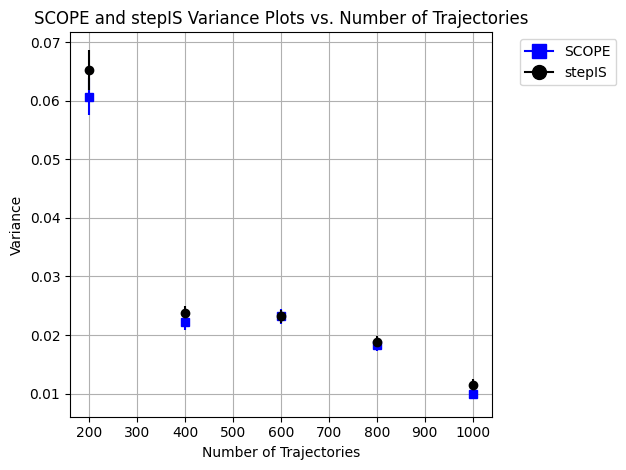

<Figure size 640x480 with 0 Axes>

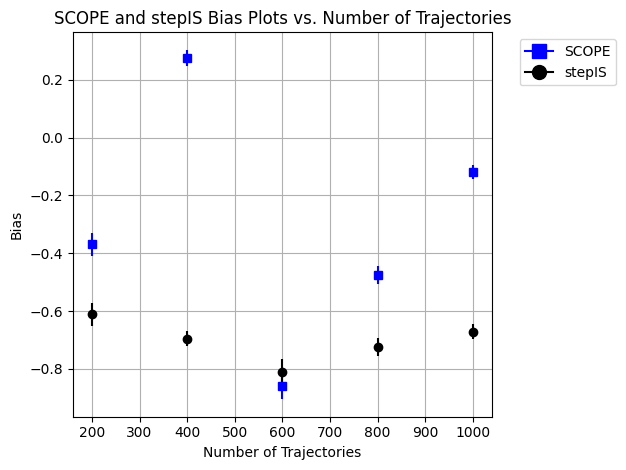

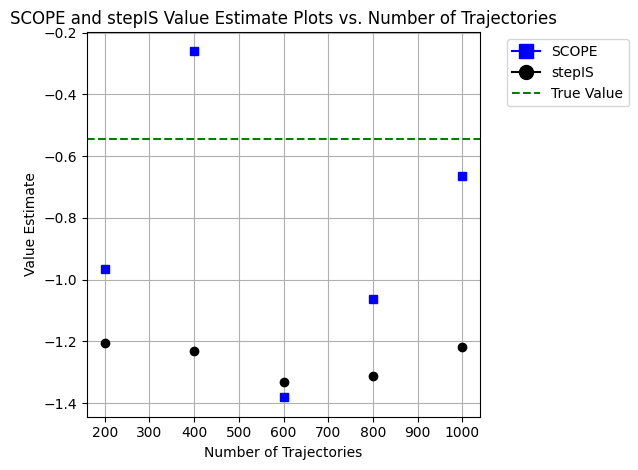

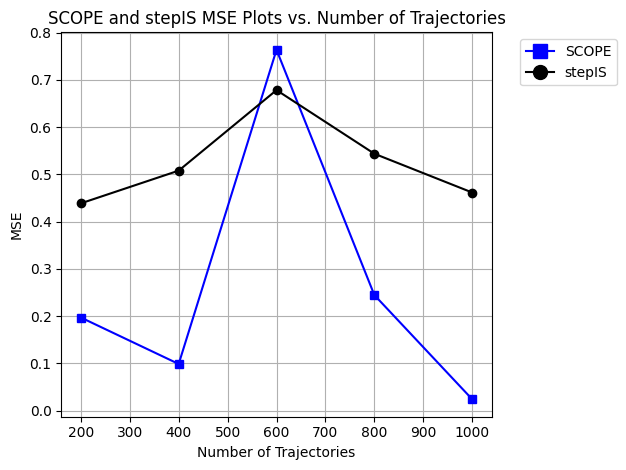

In [42]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [(3,3)], 1, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
# for i in num_trajectories:
#   print('num_trajectories: ', i)
#   modify_data(env, i, behav_policy, eval_policy, 0.3,0.1)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1 )

In [ ]:
env = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [(3,3)], 1, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
modify_data(env, 1000, behav_policy, eval_policy , 0.3, 0.1)

{'std_deviation': 0.11310456761958067, 'quartiles': array([-0.85725784, -0.60863159, -0.53575049, -0.46137109, -0.20899391]), 'mean': -0.5315890097986165, 'var_var': 2.9969427226665104, 'var_mean': 9.273830747534241}
{'std_deviation': 0.11100900635859154, 'quartiles': array([-1.2245216 , -1.00892533, -0.94189034, -0.85567247, -0.60279287]), 'mean': -0.9356929565314843, 'var_var': 1.7531922307884944, 'var_mean': 9.141444824264669}


## Sparse 2 good, 1 bad

Trajectories:  200
True Val:  [0.29732115634824036, 0.36014961229293524, 0.3349857116218308, 0.33928016877933426, 0.3723420206366827]
Optimal Beta:  [-0.17285056  0.18494393 -0.02456277]
SCOPE Results:  {'std_devs_list': [0.19620569344797842, 0.20190522413050876, 0.1867435063543737, 0.19924099001788023, 0.19060258624622556], 'mean_list': [-0.7995014179002689, -0.7863861694934197, -0.7910993749167914, -0.8079610228941839, -0.8006601583624179]}
IS Results:  {'std_devs_list': [0.20838676709718773, 0.21479786853347851, 0.19519808575683523, 0.20946807266672557, 0.2009405432845928], 'mean_list': [-0.34880244464659316, -0.335124675068263, -0.34066261951270177, -0.35272864944371973, -0.3513112566737322]}
Trajectories:  400
True Val:  [0.33197931331888986, 0.3402186081514484, 0.3271597750158513, 0.3457640954052116, 0.3389421889941216]
Optimal Beta:  [-0.37403031  0.25704897  0.05715322]
SCOPE Results:  {'std_devs_list': [0.14117311380317765, 0.12413083928880957, 0.12602766044229524, 0.134366192

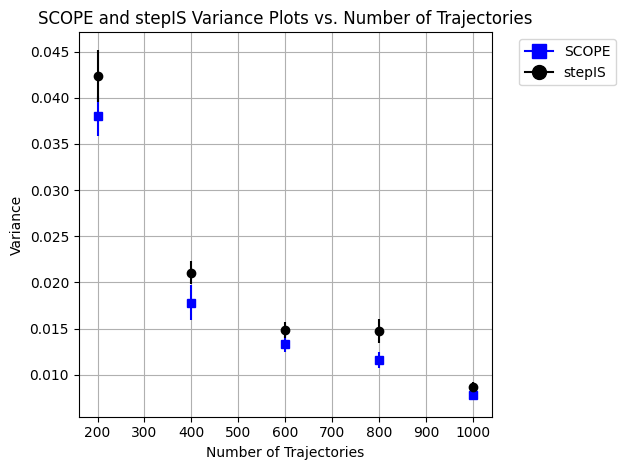

<Figure size 640x480 with 0 Axes>

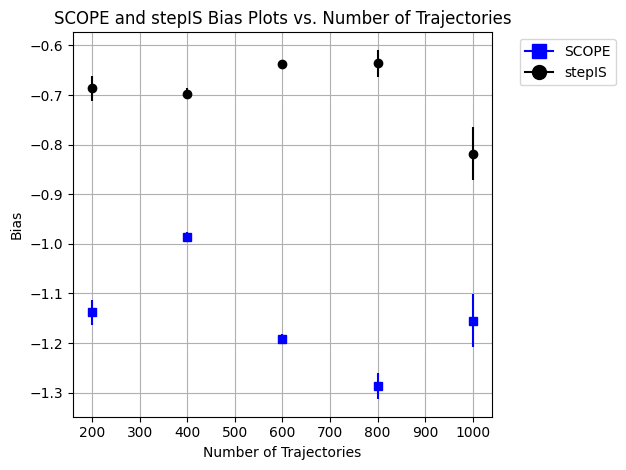

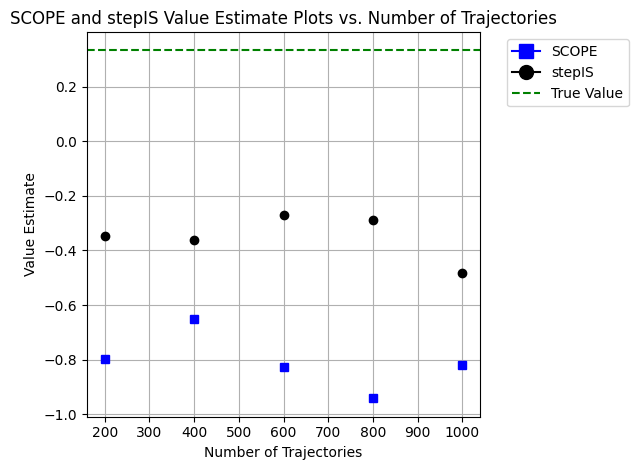

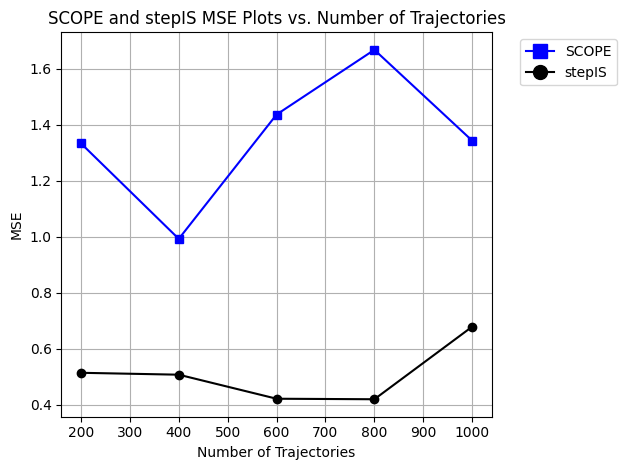

In [43]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(1, 1)], [(2, 2),(3,3)], 1, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
# for i in num_trajectories:
#   print('num_trajectories: ', i)
#   modify_data(env, i, behav_policy, eval_policy, 0.3,0.1)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1 )

In [ ]:
np.random.seed(31)
# Gridworld environment
height = 5
width  = 5
start = (0,0)
end = (4,4)

In [ ]:
env = GridWorld(height, width, start, end, [(1, 1)], [(2, 2),(3,3)], 1, -2, 3, 0.101)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.101)

## Sparse, 1 bad 1 good

Number of trajectories:  200
Number of trajectories:  400
Number of trajectories:  600
Number of trajectories:  800
Number of trajectories:  1000
Trajectories:  200
True Val:  [0.12453567821666692, 0.14118332935546915, 0.09734362386568945, 0.08958992696763227, 0.11364504064763634]
SCOPE Results:  {'std_devs_list': [0.21109752973239823, 0.22344981973803424, 0.23393052576058404, 0.22250046563304968, 0.2351582538478198], 'mean_list': [-1.3008731794337063, -1.314132895125408, -1.3030597057046935, -1.305117361198494, -1.289427752184126]}
IS Results:  {'std_devs_list': [0.23188097340777217, 0.22423788597522945, 0.21003656678421856, 0.21220724250568831, 0.21424056591733975], 'mean_list': [-0.6051550077967607, -0.6018536147527841, -0.5976547437780922, -0.6099640461876848, -0.6080557908845752]}
mse_scope:  2.055242086209014
Trajectories:  400
True Val:  [0.03553208983966581, 0.13359710024421706, 0.09587552377328194, 0.12497268868757395, 0.11924542875086705]
SCOPE Results:  {'std_devs_list': [0.

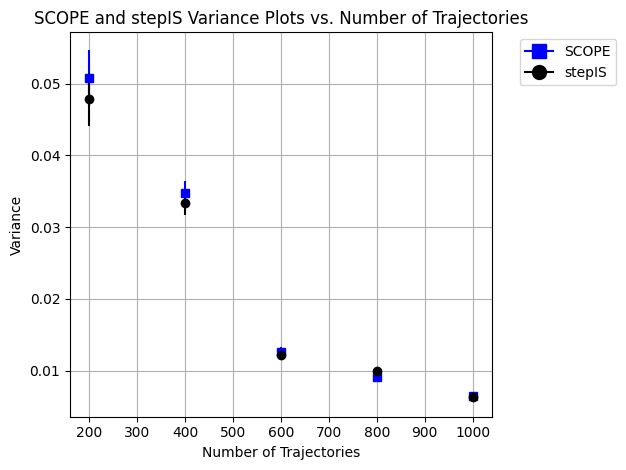

<Figure size 640x480 with 0 Axes>

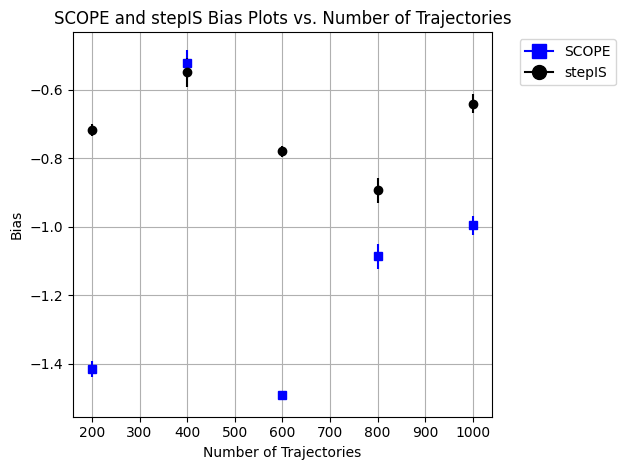

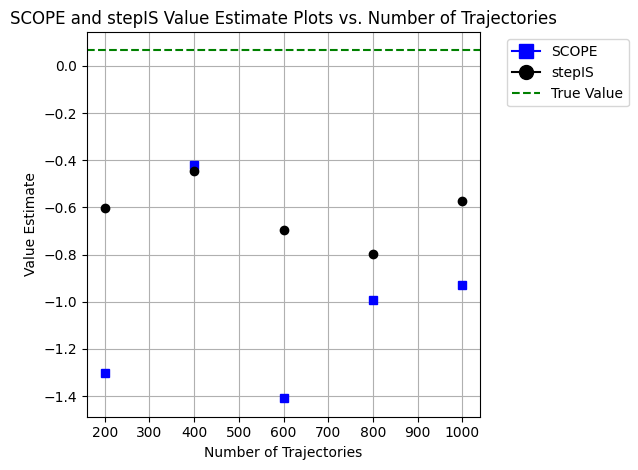

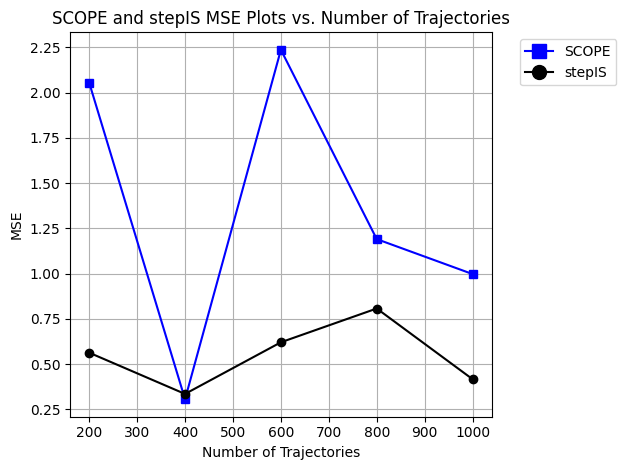

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(1, 1)], [(3,3)], 1, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
# for i in num_trajectories:
#   print('num_trajectories: ', i)
#   modify_data(env, i, behav_policy, eval_policy, 0.3,0.1)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1 )

### Same rewards for bad and good regions

Number of trajectories:  200
Number of trajectories:  400
Number of trajectories:  600
Number of trajectories:  800
Number of trajectories:  1000
Trajectories:  200
True Val:  [0.47543198969300704, 0.4853174678373497, 0.5312191236301073, 0.48309990687084037, 0.5163975533059733]
SCOPE Results:  {'std_devs_list': [0.2570238056408171, 0.2675371638564527, 0.28750682402499633, 0.277376175254234, 0.2899364326272044], 'mean_list': [-1.25302040230273, -1.2690217661142602, -1.258930291926708, -1.258526914987264, -1.2411324318157804]}
IS Results:  {'std_devs_list': [0.2986059674247444, 0.2851455768720003, 0.26134732336546956, 0.27863666994945463, 0.28311604333088997], 'mean_list': [-0.3363385898278785, -0.3363923260356249, -0.3343006262804698, -0.3399152749282182, -0.339473369029464]}
mse_scope:  3.1542476709620466
Trajectories:  400
True Val:  [0.5024227557650842, 0.4958317913576767, 0.551923570891666, 0.4574595178882978, 0.5214055751986848]
SCOPE Results:  {'std_devs_list': [0.2719499182488405

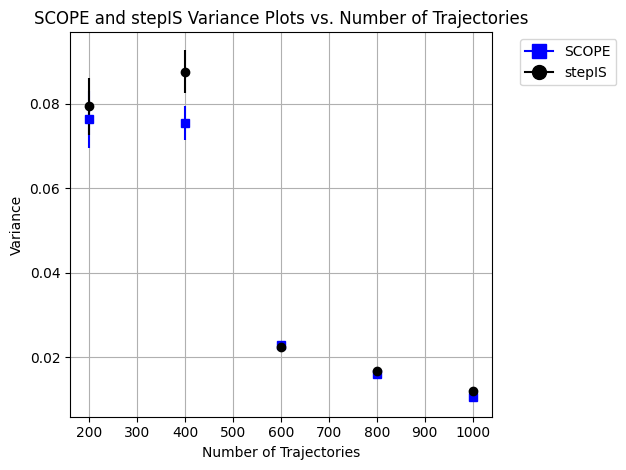

<Figure size 640x480 with 0 Axes>

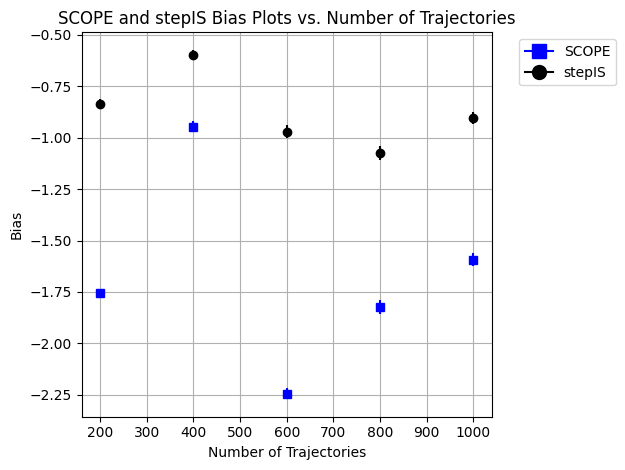

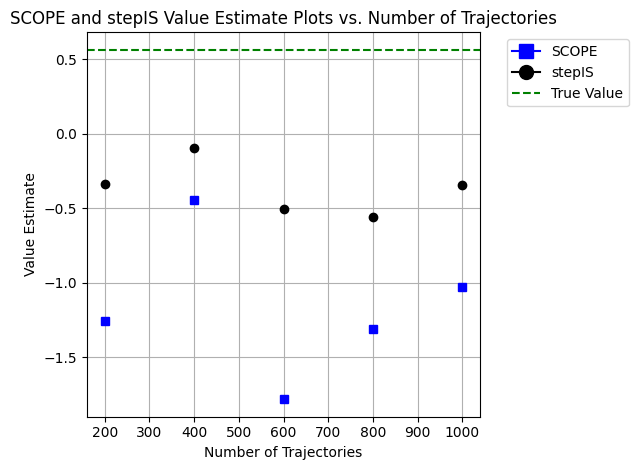

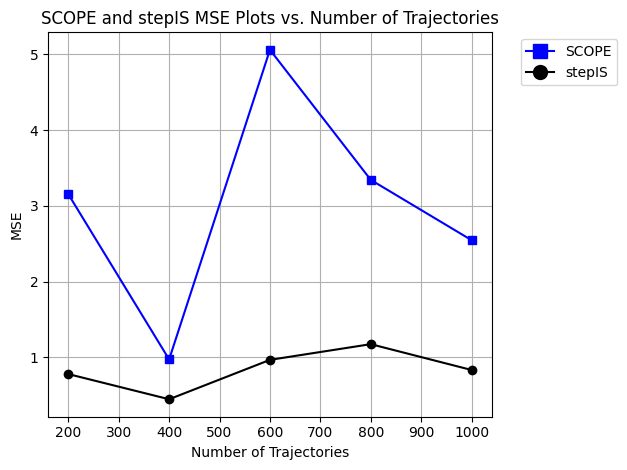

In [ ]:
env = GridWorld(height, width, start, end, [(1, 1)], [(3,3)], 2, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
# for i in num_trajectories:
#   print('num_trajectories: ', i)
#   modify_data(env, i, behav_policy, eval_policy, 0.3,0.1)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1 )

## Dense 2 bad

num_trajectories:  200
modifying... 
scope new:  {'std_devs_list': [0.34125247508338596, 0.37695643604396006, 0.3690747337342473, 0.35575556968290073, 0.36042477471261036], 'mean_list': [1.3562409597115879, 1.32873494056861, 1.3198485365801313, 1.3410032586664966, 1.3477080339873633]}
IS new:  {'std_devs_list': [0.3570254948793416, 0.36622209244339815, 0.3419623844681428, 0.3557994701456638, 0.35844352980689315], 'mean_list': [0.9192905441141404, 0.9697089693282867, 0.954699176132607, 0.9663452850538449, 0.9672424976561989]}
num_trajectories:  400
modifying... 
scope new:  {'std_devs_list': [0.40803220389835915, 0.42701131814502635, 0.3944399520472307, 0.4146192239795352, 0.4126015557550382], 'mean_list': [2.26199684637099, 2.230218667460976, 2.2727058292669198, 2.236610736669965, 2.2571224731440616]}
IS new:  {'std_devs_list': [0.37984038841141793, 0.369760048030014, 0.38383738803280665, 0.3740946619471465, 0.37263258683113126], 'mean_list': [1.4670187835888147, 1.426936143862633, 1.4

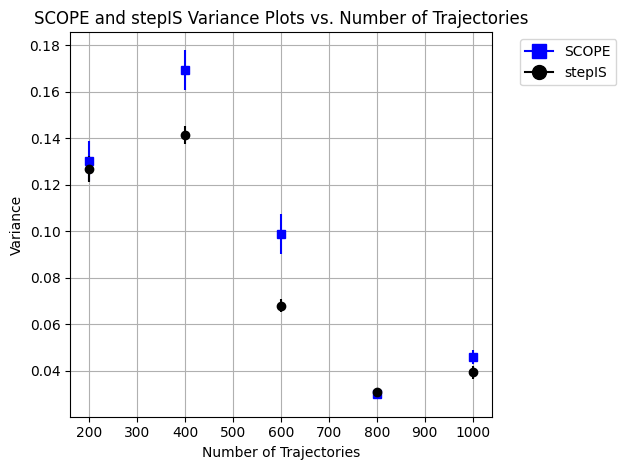

<Figure size 640x480 with 0 Axes>

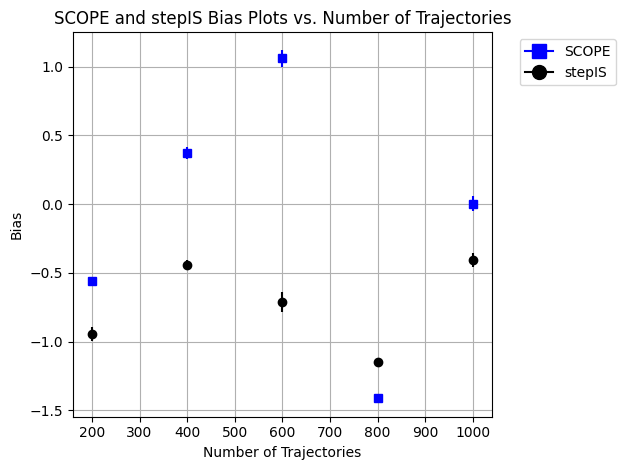

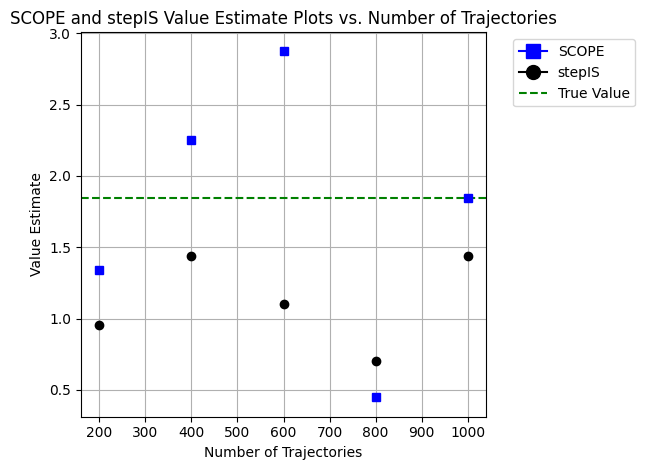

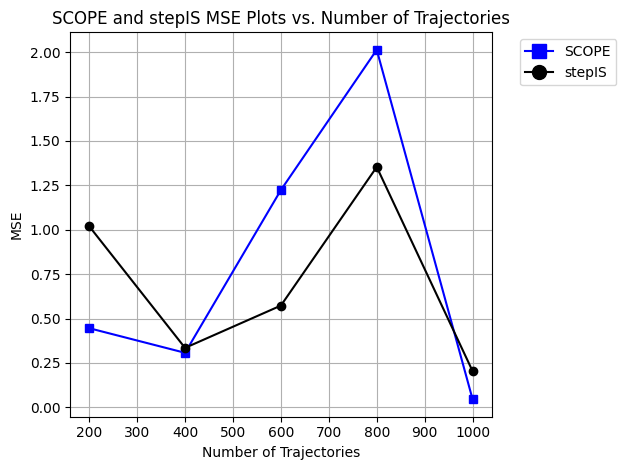

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [], 1, -2, 3, 0.9)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
# for i in num_trajectories:
#   print('num_trajectories: ', i)
#   modify_data(env, i, behav_policy, eval_policy, 0.3,0.9)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.9 )

num_trajectories:  200
modifying... 
scope new:  {'std_devs_list': [0.3099922451495932, 0.3072072202231848, 0.3136511488953343, 0.303653880730714, 0.32705206326146535], 'mean_list': [1.016841852470398, 0.9758491458294232, 0.9673283999661169, 0.9869354139078703, 0.997421004088285]}
IS new:  {'std_devs_list': [0.359207596666885, 0.35818885848489573, 0.36922876008586863, 0.364838937605864, 0.3561048013339009], 'mean_list': [1.763561607679472, 1.7541165855214607, 1.771704489962589, 1.7913008935728485, 1.7374531112819644]}
num_trajectories:  400
modifying... 
scope new:  {'std_devs_list': [0.3058460206599593, 0.3094351132264669, 0.3026229037041848, 0.3235851456504316, 0.31172099296555267], 'mean_list': [1.8683926843003482, 1.866789277349382, 1.84725265139985, 1.8726935264853641, 1.8592335583474018]}
IS new:  {'std_devs_list': [0.3188358326671611, 0.31302223139305846, 0.31996525647678664, 0.3122746417524446, 0.3260283351152563], 'mean_list': [1.8826977652793215, 1.8840764652017166, 1.8791087

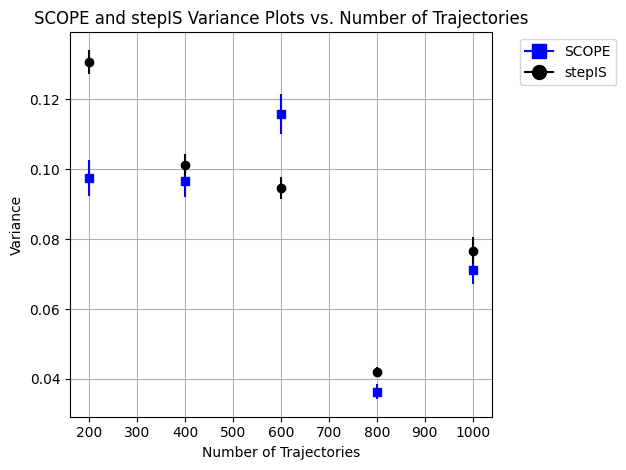

<Figure size 640x480 with 0 Axes>

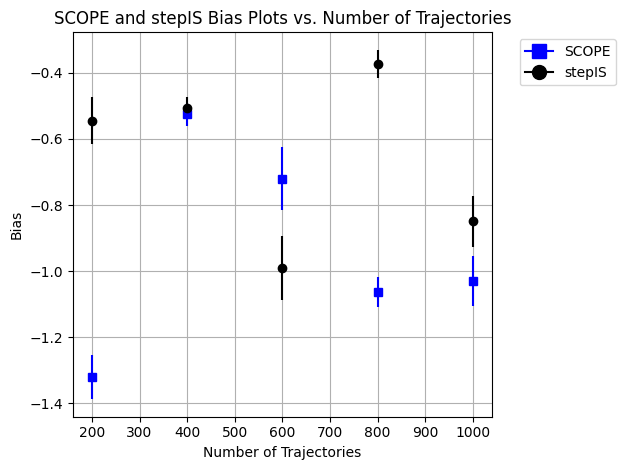

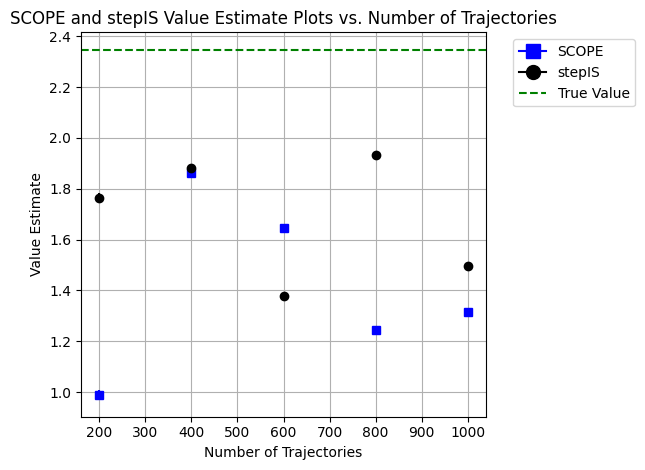

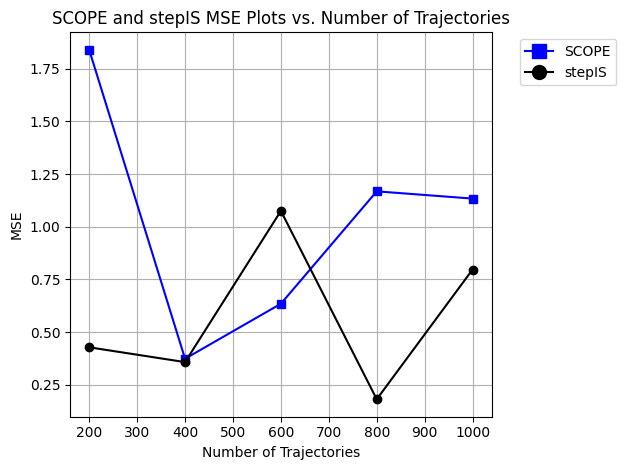

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(1, 2), (1, 4)], [], 1, -2, 3, 0.9)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
for i in num_trajectories:
  print('num_trajectories: ', i)
  modify_data(env, i, behav_policy, eval_policy, 0.3,0.9)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.9 )

num_trajectories:  200
num_trajectories:  400
num_trajectories:  600
num_trajectories:  800
num_trajectories:  1000
Number of trajectories:  200
Iteration: 1
Beta: [0.341868   0.09470684]
Variance Scope: 0.2100450235647382
----------
Var SCOPE_phi:  0.24553427628308733
Var IS_phi:  0.19024952625403854
Percent change in variance:  29.059073690006215
SCOPE results:  {'std_devs_list': [0.38289386987531204, 0.3910708307748702, 0.35870921200747863, 0.3417150546220547, 0.361088971575939], 'mean_list': [0.435444552301633, 0.3893434537304094, 0.4180680347196976, 0.4019020786753142, 0.42769860973326473]}
IS results:  {'std_devs_list': [0.34844291285224027, 0.3598989400349517, 0.3517996043312811, 0.34759403205288325, 0.3638819280939395], 'mean_list': [0.9581813401802972, 0.9820973938097266, 0.9473435494392675, 0.9535242560989695, 0.965180991945269]}
true eval:  1.8273681753238809
Number of trajectories:  400
Iteration: 1
Beta: [0.28279881 0.36761859]
Variance Scope: 0.4365185112239952
----------

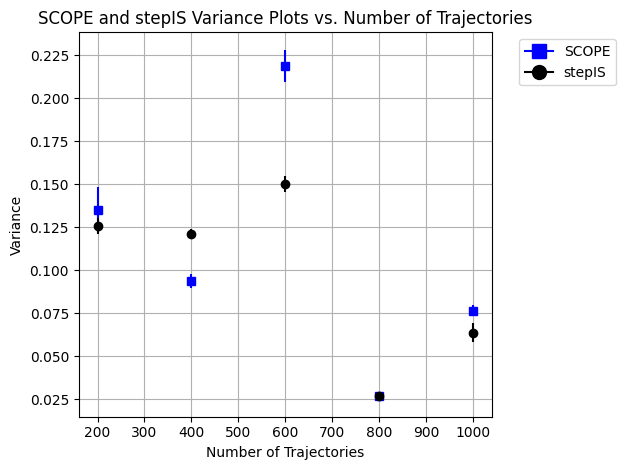

<Figure size 640x480 with 0 Axes>

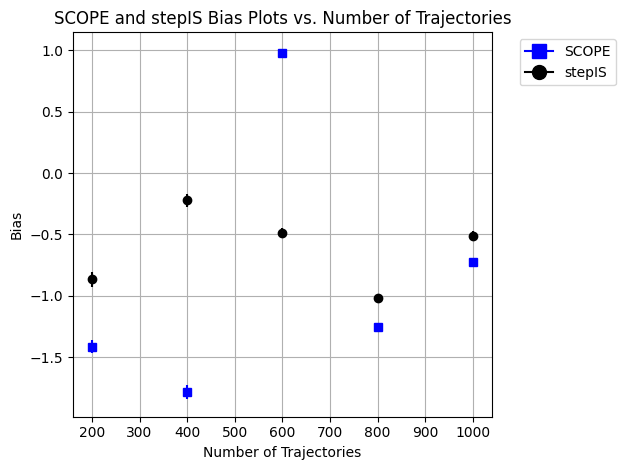

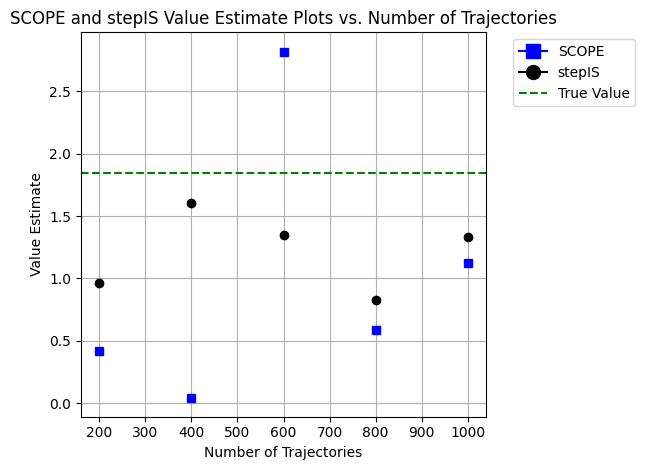

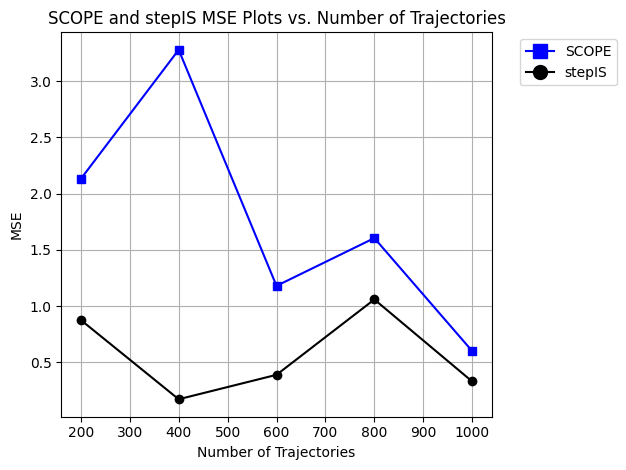

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [], 1, -2, 3, 0.88)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
for i in num_trajectories:
  print('num_trajectories: ', i)
  modify_data(env, i, behav_policy, eval_policy, 0.3,0.88)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.88)

## Dense 2 bad, 0.7 for training

In [ ]:
env = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [], 1, -2, 3, 0.9)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
# for i in num_trajectories:
#   run_experiment(env,i ,behav_policy, eval_policy, 0.3, 0.9)
#   print(i," trajectories done")
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.7, 0.9 )

## Sparse 2 bad

num_trajectories:  200
modifying... 
scope new:  {'std_devs_list': [0.3348832456427665, 0.32315936955031216, 0.334771319385379, 0.3182849853684636, 0.3205811341623111], 'mean_list': [-2.049702128487579, -2.091402038899513, -2.0619932744666776, -2.0972115062850283, -2.073418689884973]}
IS new:  {'std_devs_list': [0.2859442194490689, 0.31032424627114236, 0.29874071931492024, 0.29827306689236227, 0.2954406287541332], 'mean_list': [-1.423848513155297, -1.3974245025840333, -1.411361615393475, -1.4479685487559835, -1.4443755230374011]}
num_trajectories:  400
modifying... 
scope new:  {'std_devs_list': [0.16073707872032156, 0.15363948618857548, 0.16485200222022053, 0.15958583384906294, 0.16245271286313037], 'mean_list': [-0.14025479114721212, -0.14348384011743054, -0.14064994742374917, -0.1460435896542959, -0.12460778345842939]}
IS new:  {'std_devs_list': [0.17622563194460167, 0.16717161654791643, 0.1695046112252045, 0.17690608953332665, 0.17775844136777613], 'mean_list': [-1.3531751311333244

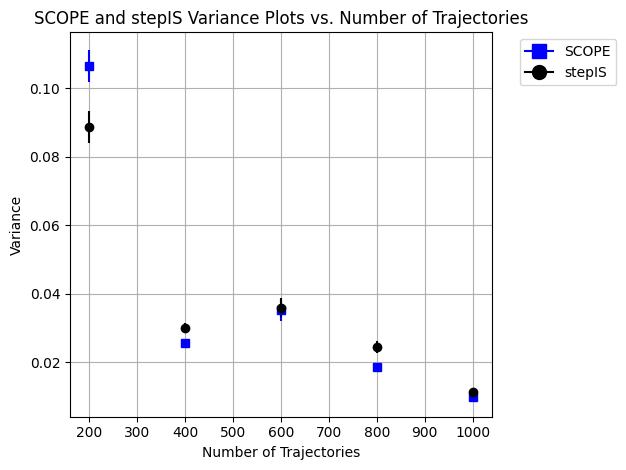

<Figure size 640x480 with 0 Axes>

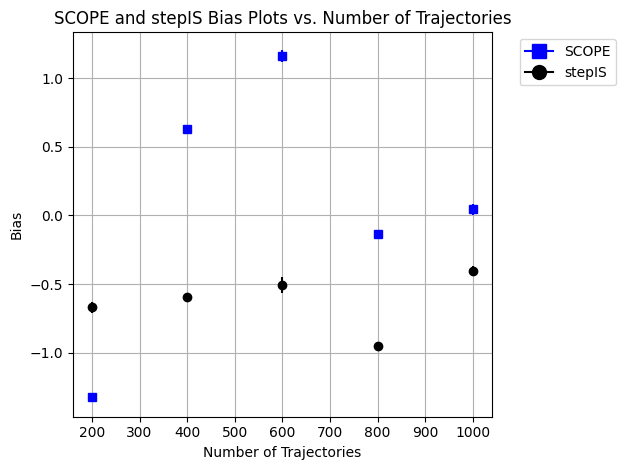

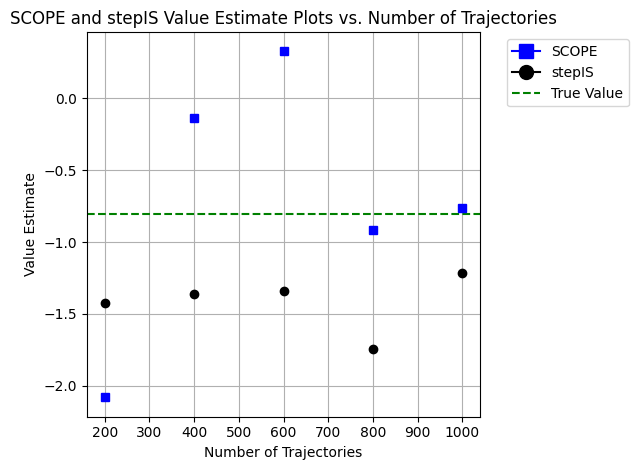

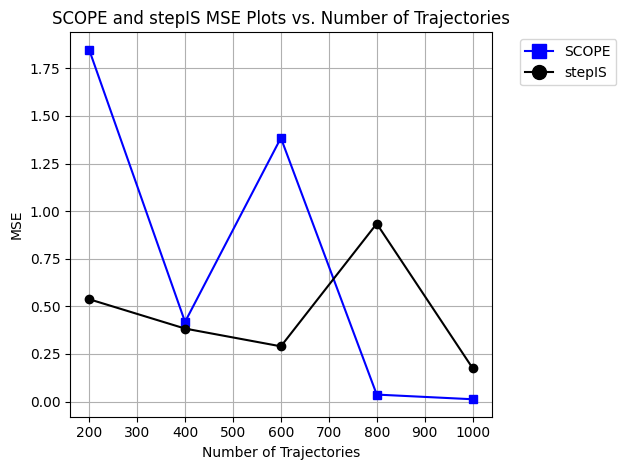

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [], 1, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
for i in num_trajectories:
  print('num_trajectories: ', i)
  modify_data(env, i, behav_policy, eval_policy, 0.3,0.1)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

num_trajectories:  200
modifying... 
scope new:  {'std_devs_list': [0.32322559157149067, 0.31511515286090147, 0.3262835694812765, 0.3106157984597823, 0.31145878920187664], 'mean_list': [-1.6061200811140048, -1.6464408830541108, -1.6183232508397902, -1.657261783986869, -1.6285666819127385]}
IS new:  {'std_devs_list': [0.27874781718563607, 0.3002422045717546, 0.2909668462224771, 0.291771007937127, 0.2876740330743961], 'mean_list': [-0.9733633518022239, -0.9525839628730068, -0.9627414423844864, -0.996497293501647, -0.9973342626536014]}
num_trajectories:  400
modifying... 
scope new:  {'std_devs_list': [0.16685302848341613, 0.15731659285414654, 0.16798962912360538, 0.16546547417699833, 0.16742756473342987], 'mean_list': [0.3022228809645723, 0.3033720205119344, 0.30489679891879745, 0.30019952774164893, 0.32112298927668453]}
IS new:  {'std_devs_list': [0.1734122865711688, 0.1641312628371137, 0.16558169616932908, 0.17265641264356946, 0.17245830950285732], 'mean_list': [-0.8486955742475552, -0

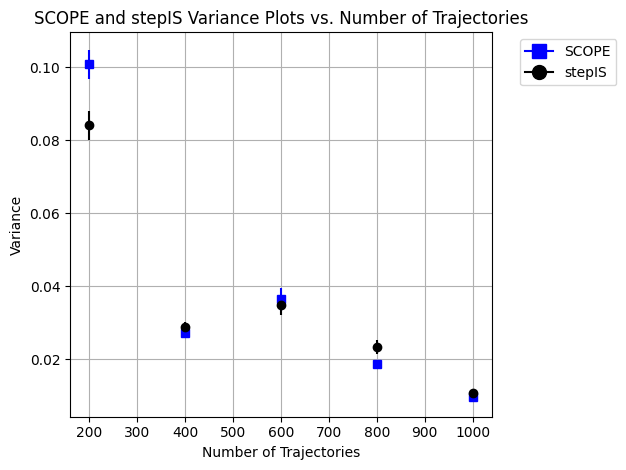

<Figure size 640x480 with 0 Axes>

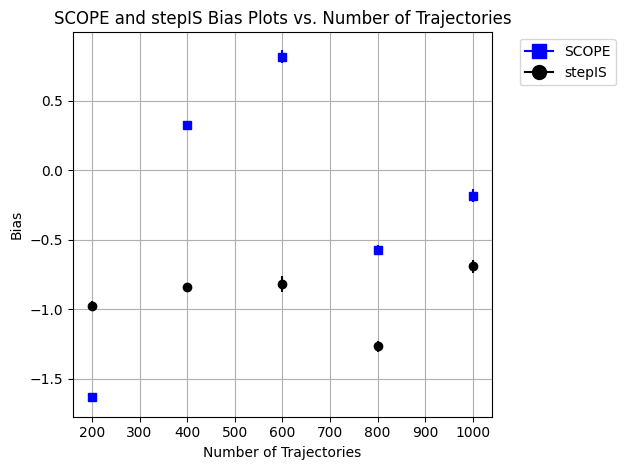

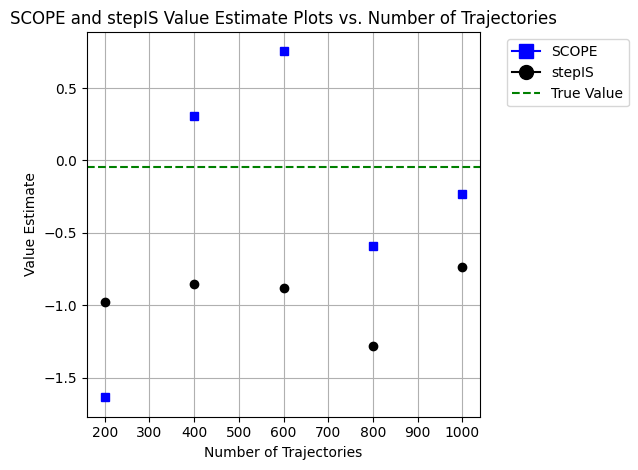

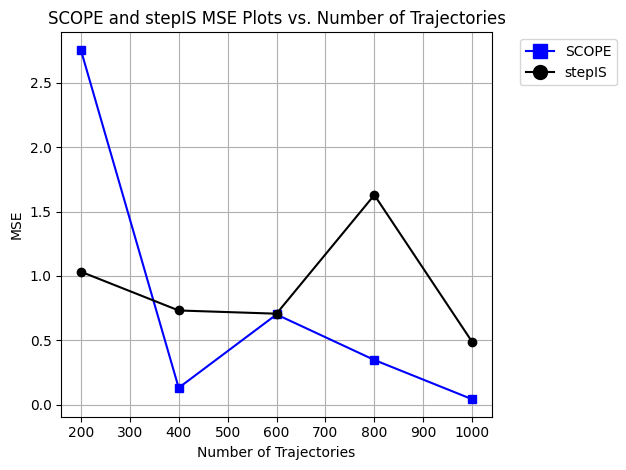

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [], 1, -2, 3, 0.2)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
for i in num_trajectories:
  print('num_trajectories: ', i)
  modify_data(env, i, behav_policy, eval_policy, 0.3,0.2)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.2)

num_trajectories:  200
modifying... 
scope new:  {'std_devs_list': [0.2603965028163117, 0.2704664365803131, 0.27109384435367856, 0.27975062433062853, 0.27007395202464934], 'mean_list': [0.4611687925903294, 0.449310102982123, 0.4580404334660843, 0.435705648205131, 0.46982298424488883]}
IS new:  {'std_devs_list': [0.255804977858809, 0.2725380348330551, 0.26269870118147814, 0.2654792260523955, 0.2756230830705112], 'mean_list': [-1.14232849113572, -1.1283974196015756, -1.139988900597999, -1.1576554310499925, -1.137678855176574]}
num_trajectories:  400
modifying... 
scope new:  {'std_devs_list': [0.20270576366142956, 0.20764382169560908, 0.20733374301289953, 0.19539791808339307, 0.200474857432345], 'mean_list': [0.4832320621083126, 0.48355180397382963, 0.4947397113417486, 0.4865369776774845, 0.4898331762836114]}
IS new:  {'std_devs_list': [0.18659820342045938, 0.17971492636261288, 0.1955395370650463, 0.18891774151094512, 0.18610211519207664], 'mean_list': [-1.393009228609224, -1.38114514478

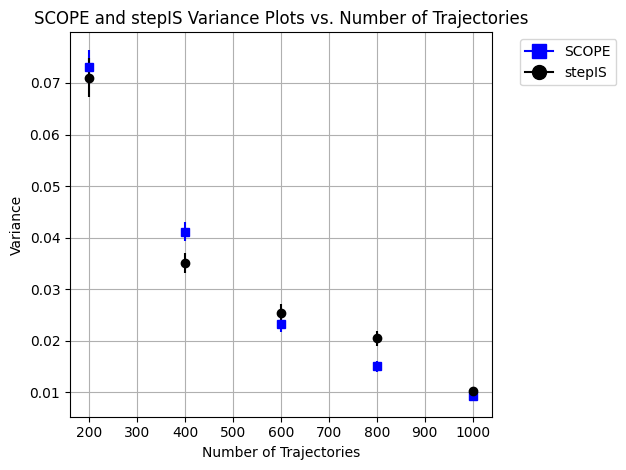

<Figure size 640x480 with 0 Axes>

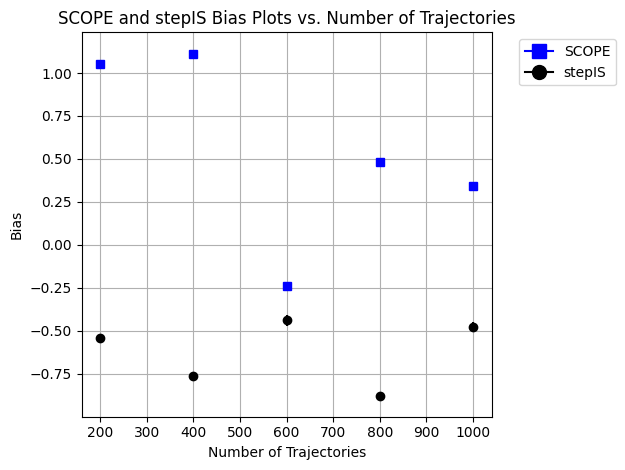

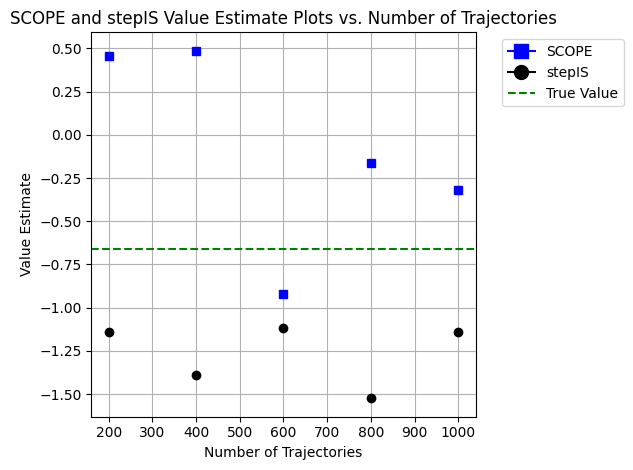

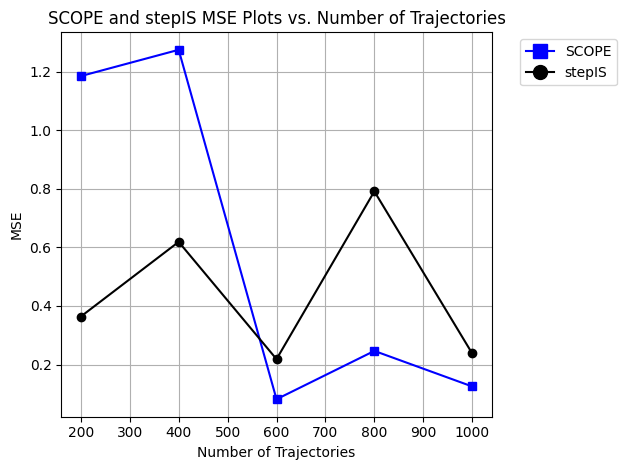

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(1, 1), (3, 2)], [], 1, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
for i in num_trajectories:
  print('num_trajectories: ', i)
  modify_data(env, i, behav_policy, eval_policy, 0.3,0.1)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

num_trajectories:  200
modifying... 
scope new:  {'std_devs_list': [0.20305965859527025, 0.20698353893817686, 0.20765973520527234, 0.19732722894437527, 0.208349524594422], 'mean_list': [-0.1255798587936603, -0.12545152583048083, -0.14588291262215955, -0.12776261412394313, -0.1276358862000834]}
IS new:  {'std_devs_list': [0.24741495753104428, 0.2395698415698099, 0.2429161394749116, 0.24909219458721912, 0.23707790975040263], 'mean_list': [-0.851973694731343, -0.8629612621162815, -0.86751170480402, -0.8752789138060043, -0.8618469794501716]}
num_trajectories:  400
modifying... 
scope new:  {'std_devs_list': [0.14447330479511908, 0.1454164886986218, 0.15346112814471854, 0.14823852953153935, 0.15466006610888366], 'mean_list': [-0.5512682495316464, -0.5349227629839219, -0.5537493704400154, -0.5589517211794182, -0.5420948706481885]}
IS new:  {'std_devs_list': [0.1762543208100756, 0.18333662582600874, 0.18209469335041417, 0.18010282776885767, 0.18879025683253295], 'mean_list': [-1.0830099974517

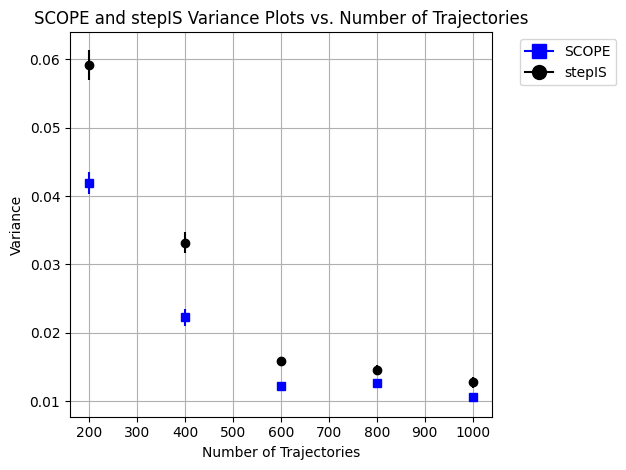

<Figure size 640x480 with 0 Axes>

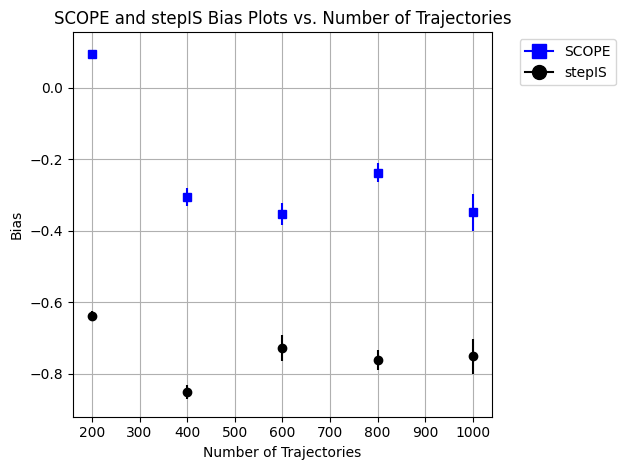

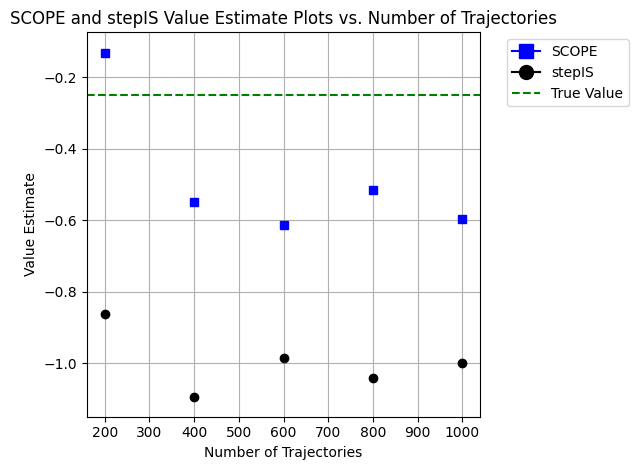

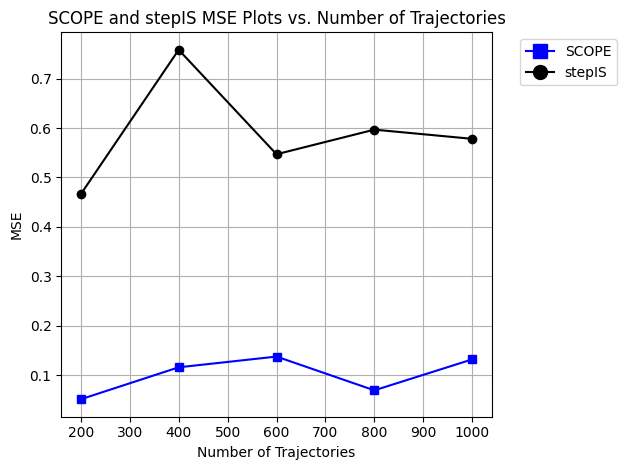

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(1, 2), (2, 3)], [], 1, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
for i in num_trajectories:
  print('num_trajectories: ', i)
  modify_data(env, i, behav_policy, eval_policy, 0.3,0.1)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

num_trajectories:  200
modifying... 
scope new:  {'std_devs_list': [0.39725845421432043, 0.3707464875697575, 0.3761472707969062, 0.38685440930167997, 0.37302038534759696], 'mean_list': [0.3524522199147209, 0.32064262937255344, 0.35057929889871026, 0.29329850974458394, 0.3423630520212799]}
IS new:  {'std_devs_list': [0.42064758597717783, 0.42840824049061677, 0.4423154723678582, 0.4428016763914589, 0.43733559600013605], 'mean_list': [-1.0833587230477515, -1.0508870744536043, -1.1023456353016028, -1.0720891334026184, -1.0897891098173629]}
num_trajectories:  400
modifying... 
scope new:  {'std_devs_list': [0.18278730516862202, 0.17424581785184315, 0.17212621684408985, 0.183286297761355, 0.1754936185992999], 'mean_list': [0.2912861528438454, 0.29067984633721794, 0.28860270324525844, 0.2860703335150105, 0.3008991893778414]}
IS new:  {'std_devs_list': [0.2823556657749363, 0.2728760844918271, 0.28523095910681473, 0.2712985684209428, 0.28233583206013185], 'mean_list': [-0.9796437226636874, -0.9

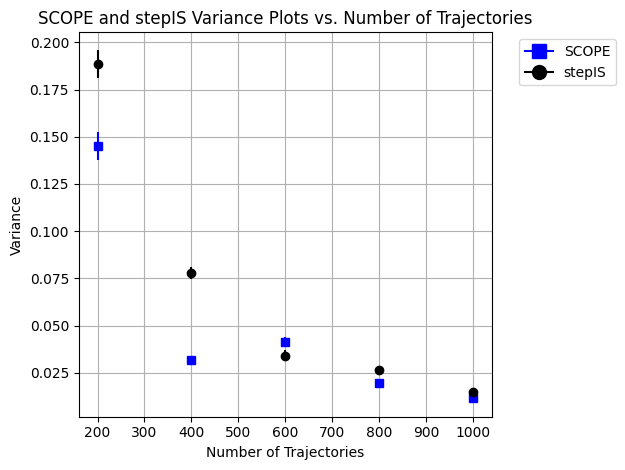

<Figure size 640x480 with 0 Axes>

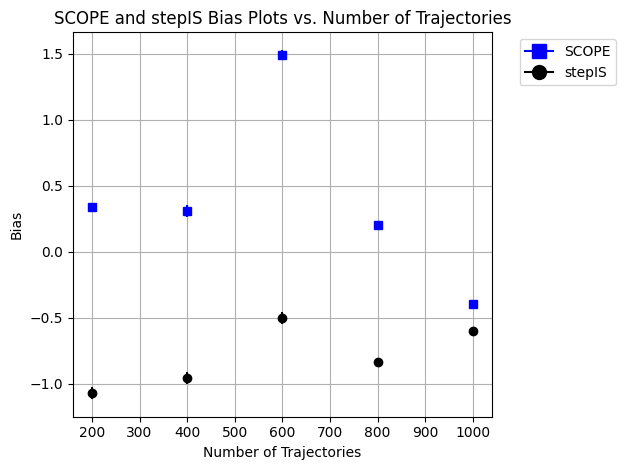

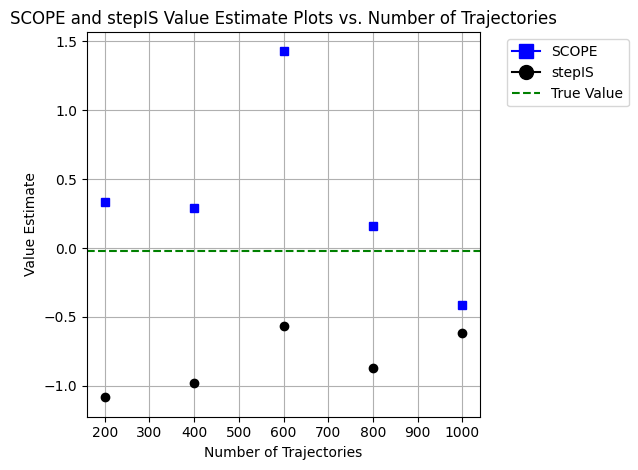

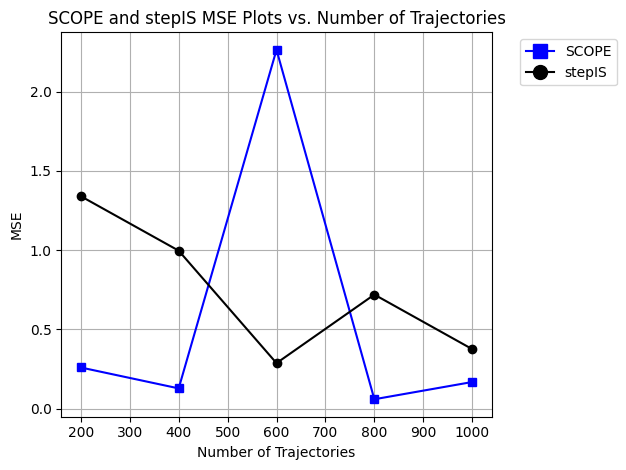

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(2, 2), (3, 3)], [], 1, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
for i in num_trajectories:
  print('num_trajectories: ', i)
  modify_data(env, i, behav_policy, eval_policy, 0.3,0.1)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

## Sparse 3 bad

num_trajectories:  200
modifying... 
scope new:  {'std_devs_list': [0.33263203634253236, 0.3089301058622253, 0.3092969528689691, 0.3167659030650054, 0.3019232121643298], 'mean_list': [-0.387040370363585, -0.3876564262804032, -0.3815312587026322, -0.3960431060588754, -0.3858016105839035]}
IS new:  {'std_devs_list': [0.3528759957002573, 0.375801799761415, 0.38537393842259915, 0.3774674445376864, 0.3780889075976483], 'mean_list': [-1.608275017691703, -1.6306648263299184, -1.6130185548515565, -1.6181960982967545, -1.623176205666319]}
num_trajectories:  400
modifying... 
scope new:  {'std_devs_list': [0.23356903495699058, 0.21907010472181582, 0.23462894858435734, 0.2336966968399446, 0.22139306810701967], 'mean_list': [-0.6121066386957998, -0.6285495073513068, -0.6231964767772783, -0.6181957287273492, -0.6016146656361452]}
IS new:  {'std_devs_list': [0.27171313751295495, 0.2917492396033783, 0.2685669831404122, 0.27346053226577366, 0.2684923085335523], 'mean_list': [-1.4951751163995515, -1.48

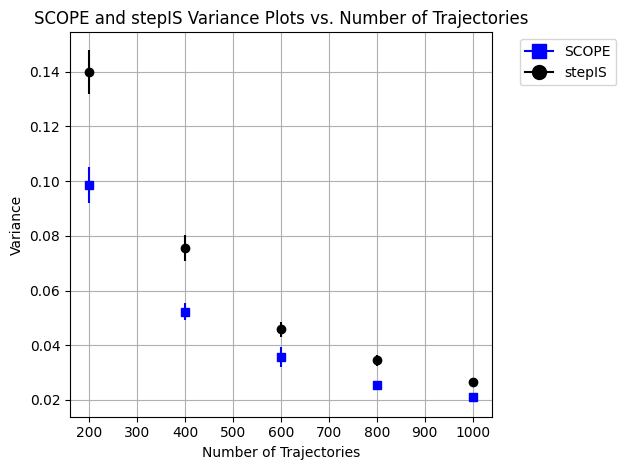

<Figure size 640x480 with 0 Axes>

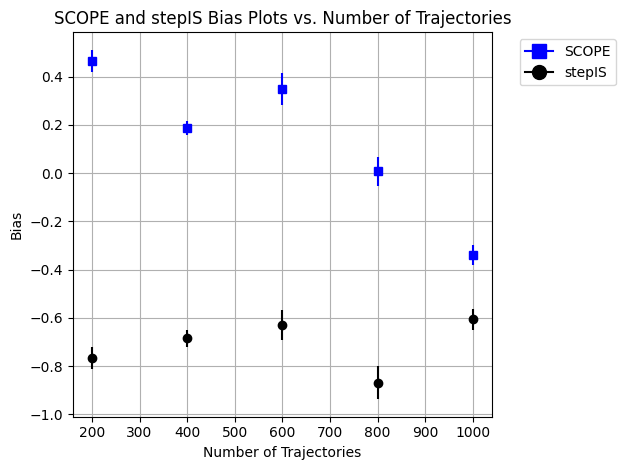

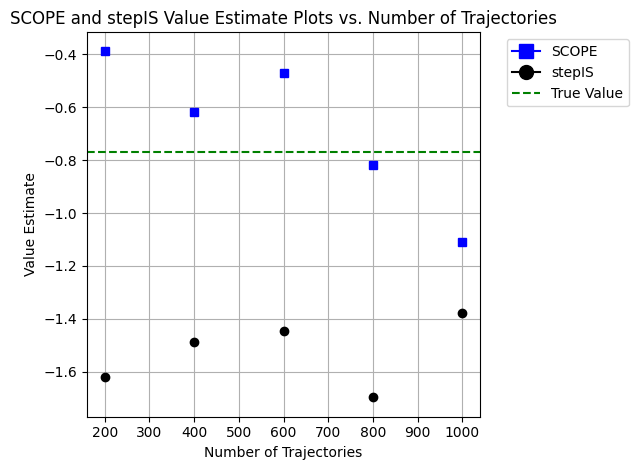

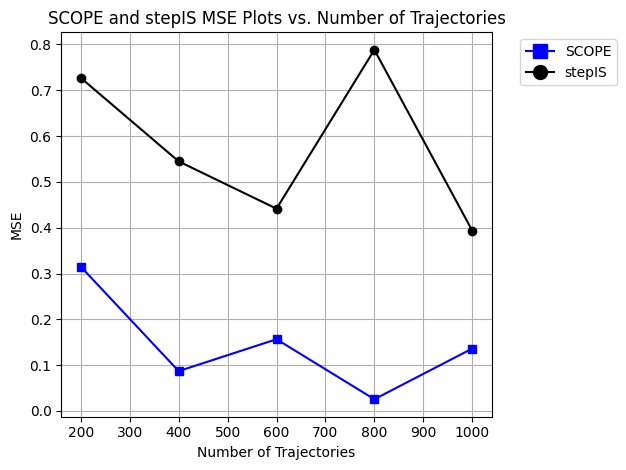

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(2, 1), (2, 2), (2,3)], [], 1, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
for i in num_trajectories:
  print('num_trajectories: ', i)
  modify_data(env, i, behav_policy, eval_policy, 0.3,0.1)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

num_trajectories:  200
modifying... 
scope new:  {'std_devs_list': [0.4429159271640935, 0.4603490618133421, 0.47596081463266016, 0.43599664729751797, 0.47615427932262117], 'mean_list': [-2.242172208123936, -2.2531280773608526, -2.2391620800378313, -2.2431967759462723, -2.287323053674491]}
IS new:  {'std_devs_list': [0.36250833309974007, 0.3908110659018321, 0.3734669999467885, 0.3642678798585173, 0.38620908486182215], 'mean_list': [-1.677045014328114, -1.67117825984734, -1.66548643904564, -1.6853235903721653, -1.6521013369300577]}
num_trajectories:  400
modifying... 
scope new:  {'std_devs_list': [0.21176651743089792, 0.20530375993105007, 0.2064793900481481, 0.21924417060202472, 0.21301133458342922], 'mean_list': [0.5645642323955913, 0.5701608538176973, 0.5761762986480194, 0.5741742263119227, 0.5639534183398173]}
IS new:  {'std_devs_list': [0.3132280742593901, 0.31140526002404867, 0.3068733529728086, 0.3117181405443095, 0.30465963972492965], 'mean_list': [-2.0163829882347213, -2.0050857

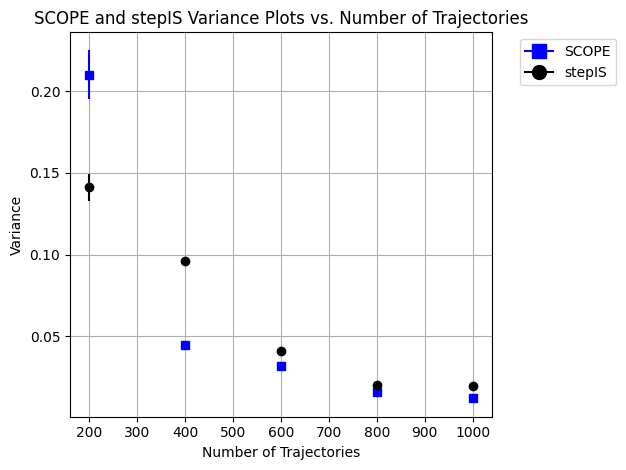

<Figure size 640x480 with 0 Axes>

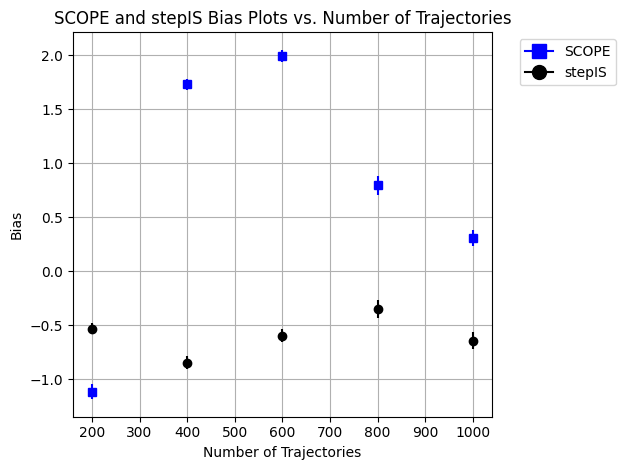

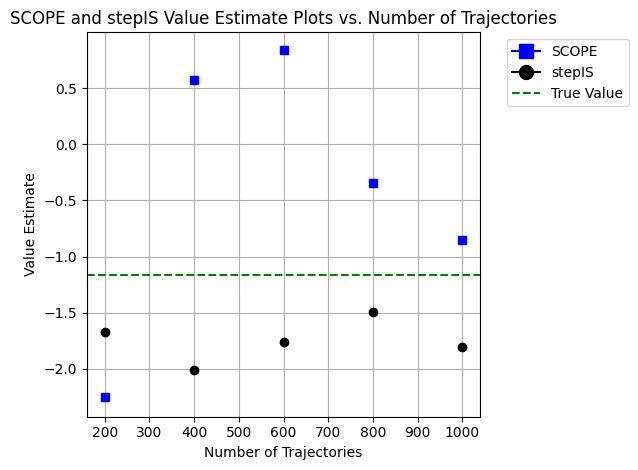

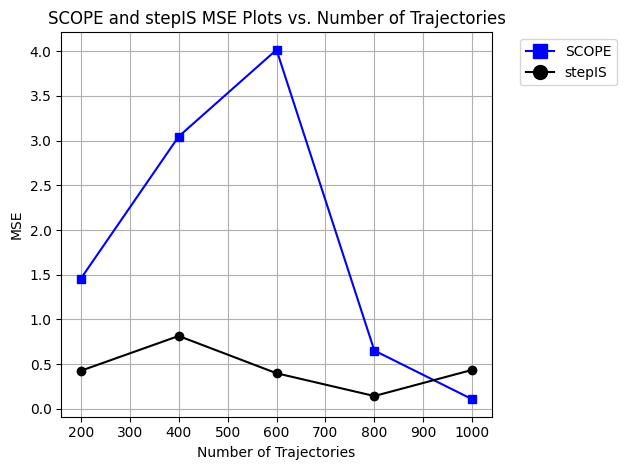

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(1, 1), (2, 2), (3,3)], [], 1, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
for i in num_trajectories:
  print('num_trajectories: ', i)
  modify_data(env, i, behav_policy, eval_policy, 0.3,0.1)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

### Mid Sparsity

num_trajectories:  200
modifying... 
scope new:  {'std_devs_list': [0.45380167306044616, 0.46794461709032553, 0.4681420994743104, 0.46496245907418465, 0.4324754724553552], 'mean_list': [-2.1464849115638756, -2.18999005549357, -2.1358026179609344, -2.20474918015787, -2.1937889186208483]}
IS new:  {'std_devs_list': [0.45843691356490973, 0.46132917036235604, 0.43889273460050254, 0.4739037787741803, 0.4638168510350164], 'mean_list': [-0.5728140236969528, -0.577227464850856, -0.5982204432400006, -0.5335876709276828, -0.5439293914686726]}
num_trajectories:  400
modifying... 
scope new:  {'std_devs_list': [0.25080756762697626, 0.26350492474076476, 0.24698178790140754, 0.2416958818853249, 0.25653194866523765], 'mean_list': [0.8447588427630396, 0.8665987431444643, 0.8523629690388441, 0.8515157466853713, 0.8472851119033378]}
IS new:  {'std_devs_list': [0.2917383675923478, 0.30454565214456153, 0.28826172787693854, 0.27774565533877027, 0.2851371116041284], 'mean_list': [-0.9418940876635022, -0.941

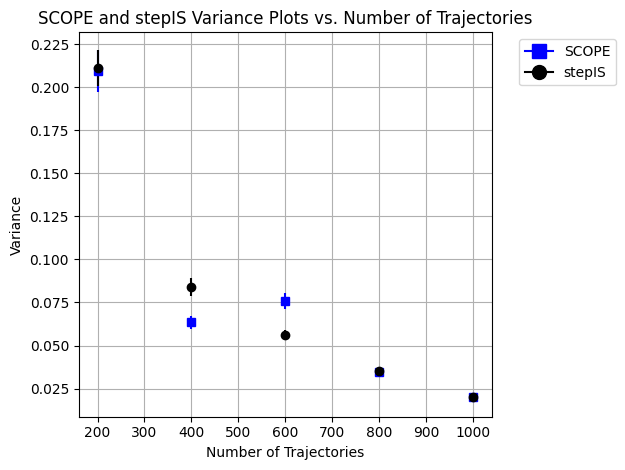

<Figure size 640x480 with 0 Axes>

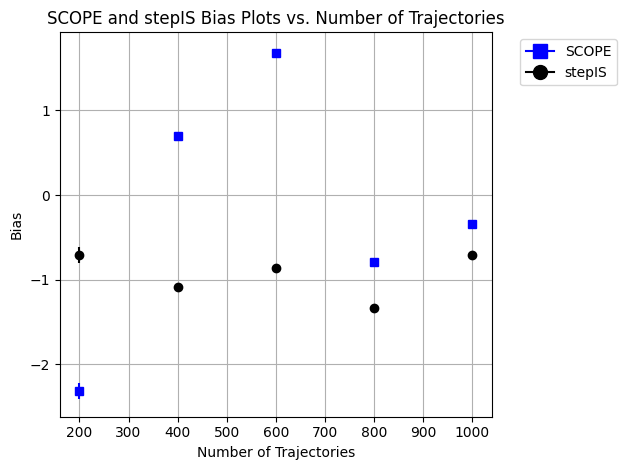

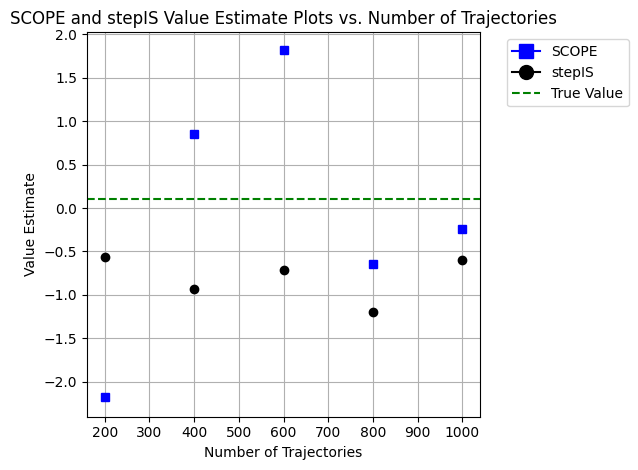

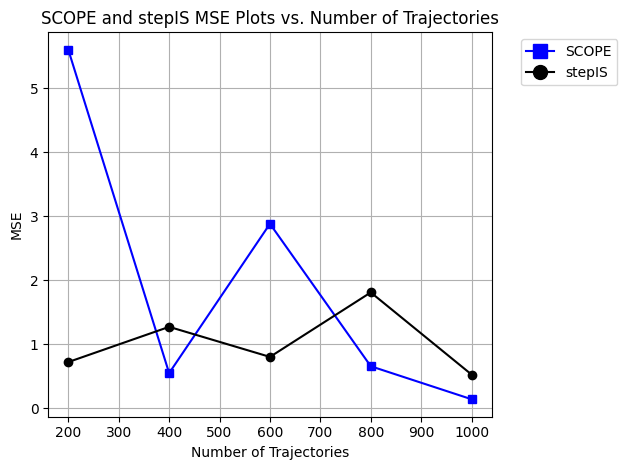

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(1, 1), (2, 2), (3,3)], [], 1, -2, 3, 0.5)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
for i in num_trajectories:
  print('num_trajectories: ', i)
  modify_data(env, i, behav_policy, eval_policy, 0.3,0.5)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.5)

## Sparse 2 good

num_trajectories:  200
modifying... 
scope new:  {'std_devs_list': [0.20464006868549267, 0.21065819116256268, 0.20093045416893798, 0.20040316508530762, 0.19878760548773328], 'mean_list': [1.1136523670297915, 1.107807601090267, 1.1038396441791902, 1.1299492235315105, 1.1243055255031698]}
IS new:  {'std_devs_list': [0.21580160701056833, 0.21219422934456914, 0.2241674886913762, 0.21385672092395472, 0.22678739446922774], 'mean_list': [1.307884282438206, 1.3049953317141707, 1.314492950127202, 1.291179824651199, 1.3229224638821557]}
num_trajectories:  400
modifying... 
scope new:  {'std_devs_list': [0.09069127990459783, 0.08688845610909578, 0.08623089075245531, 0.087167505005773, 0.08421755624082121], 'mean_list': [0.2253141472309727, 0.23262638952626138, 0.22886445851191994, 0.22448589655853907, 0.2194877300051874]}
IS new:  {'std_devs_list': [0.10627022950601524, 0.11452253879298421, 0.1119066026537887, 0.10777192134150766, 0.10637632389464384], 'mean_list': [1.0898666687657441, 1.08311435

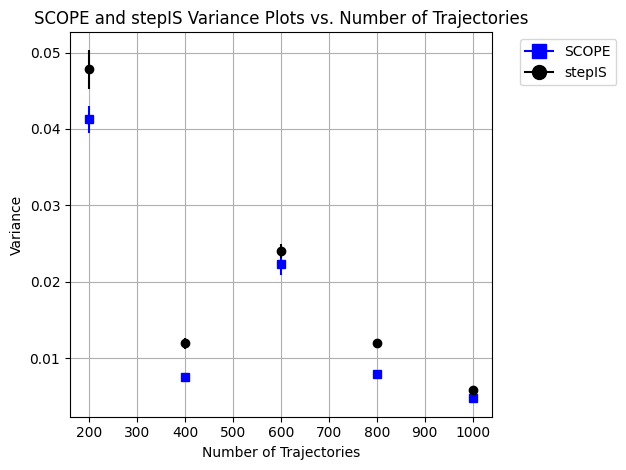

<Figure size 640x480 with 0 Axes>

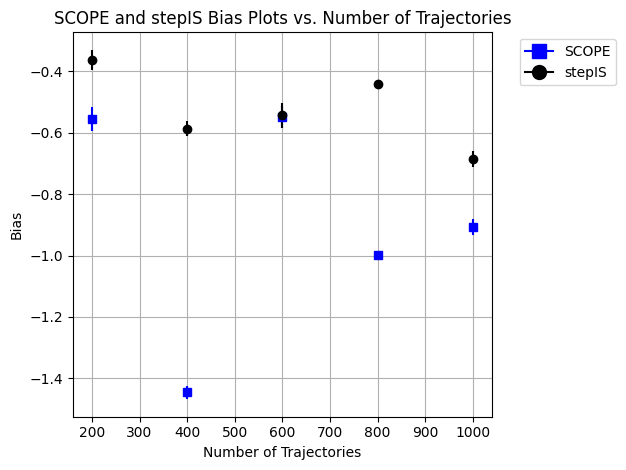

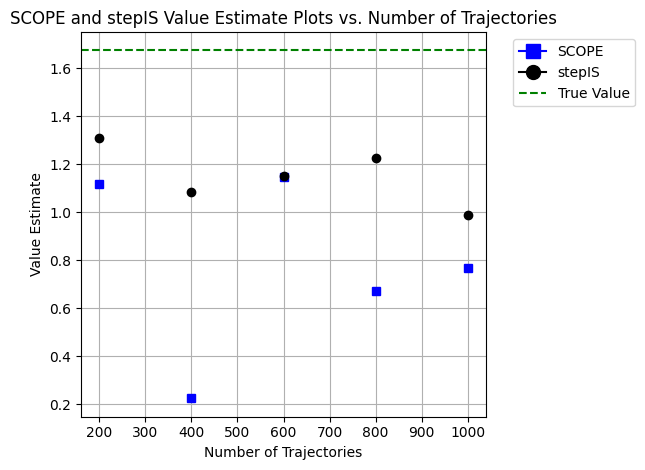

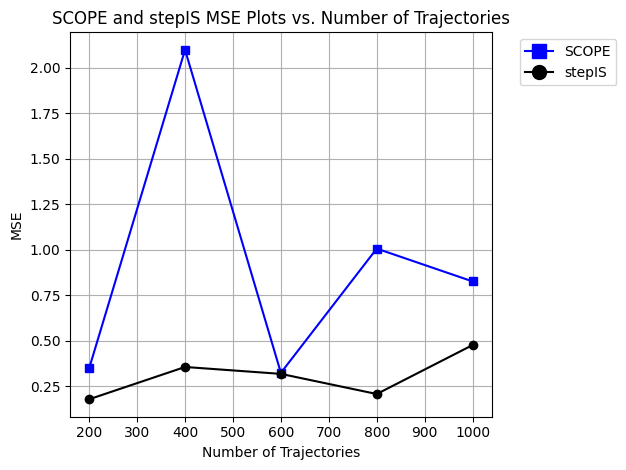

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [], [(2, 1), (2, 2)], 1, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
for i in num_trajectories:
  print('num_trajectories: ', i)
  modify_data(env, i, behav_policy, eval_policy, 0.3,0.1)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

num_trajectories:  200
modifying... 
scope new:  {'std_devs_list': [0.14428803797633227, 0.14417348184404438, 0.15211454962371376, 0.15265229579145184, 0.15117784337804102], 'mean_list': [0.884036059828334, 0.904106835567326, 0.9072215804220771, 0.8953930216978483, 0.8850110869910761]}
IS new:  {'std_devs_list': [0.192699652268452, 0.18492389967271025, 0.18603005375790888, 0.1904482008961664, 0.1865991015356931], 'mean_list': [1.2488263163676985, 1.243929918855075, 1.23027939058555, 1.2551484093826644, 1.2445578606263228]}
num_trajectories:  400
modifying... 
scope new:  {'std_devs_list': [0.09339609625540445, 0.0915769835657842, 0.09681274243749835, 0.087399178883537, 0.09321105311894197], 'mean_list': [0.42369955535158316, 0.419475840860848, 0.42622694960730184, 0.4269993275352733, 0.4130639470400431]}
IS new:  {'std_devs_list': [0.112360852676894, 0.11259851318880759, 0.11044809237315238, 0.11653520108523625, 0.11966374974549811], 'mean_list': [1.1260134434260145, 1.1262926096441244

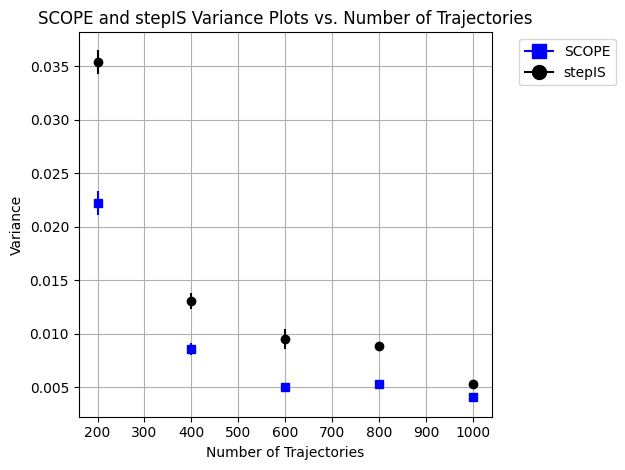

<Figure size 640x480 with 0 Axes>

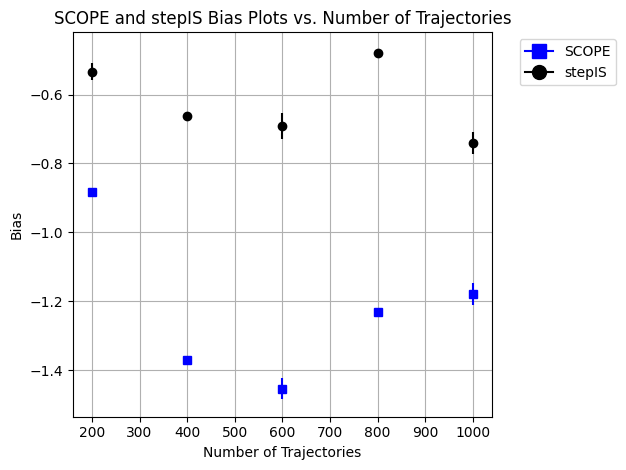

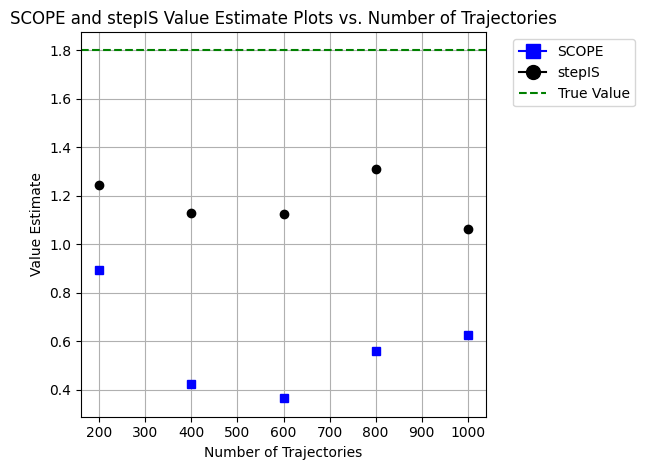

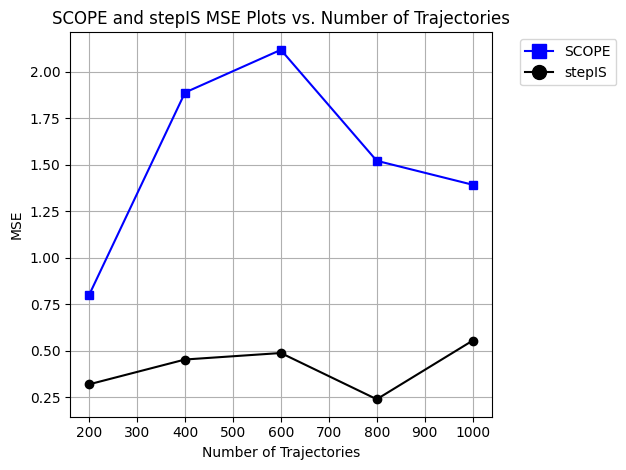

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [], [(1, 1), (2, 2)], 1, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
for i in num_trajectories:
  print('num_trajectories: ', i)
  modify_data(env, i, behav_policy, eval_policy, 0.3,0.1)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

## Sparse 1 good

num_trajectories:  200
modifying... 
scope new:  {'std_devs_list': [0.5418832231033299, 0.5619462990037858, 0.5253973305044355, 0.5341774992382882, 0.5670348309101709], 'mean_list': [2.164040973858685, 2.164984933849623, 2.101314887286076, 2.178155530607902, 2.152427658268785]}
IS new:  {'std_devs_list': [0.5302468924213624, 0.5420014020099809, 0.5538485742542923, 0.5046638046738786, 0.5110341211882468], 'mean_list': [1.6551311322264908, 1.6633916176878325, 1.6409998425958923, 1.6393590191266385, 1.6171918281440438]}
num_trajectories:  400
modifying... 
scope new:  {'std_devs_list': [0.17956256721945915, 0.18922302277111386, 0.1825557764965053, 0.18110372019379475, 0.18661754281176166], 'mean_list': [1.2673227973959529, 1.247325614459311, 1.2734939116652517, 1.2609330156655645, 1.2541314524018212]}
IS new:  {'std_devs_list': [0.17048490017273127, 0.17775523690860928, 0.1837298068252563, 0.18160662822383788, 0.1825475738527499], 'mean_list': [1.0818239115554538, 1.0708702425291436, 1.08

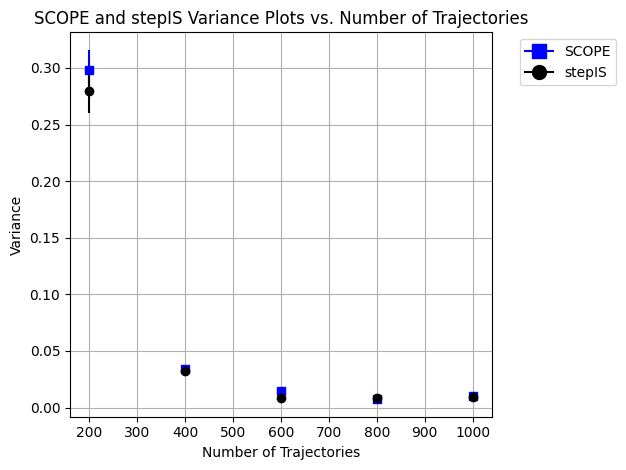

<Figure size 640x480 with 0 Axes>

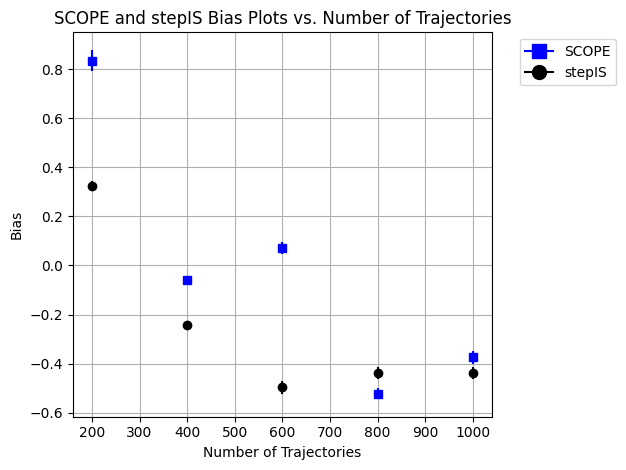

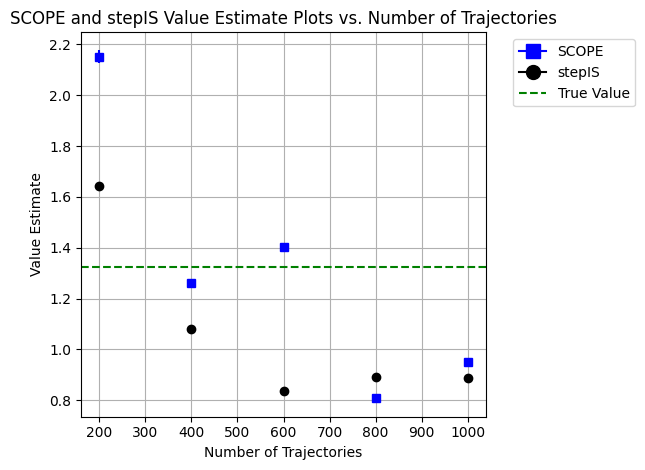

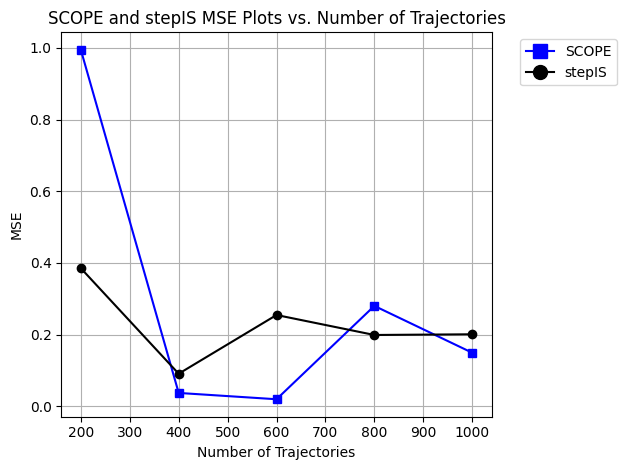

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [], [(1, 2)], 1, -2, 3, 0.1)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
for i in num_trajectories:
  print('num_trajectories: ', i)
  modify_data(env, i, behav_policy, eval_policy, 0.3,0.1)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

## Sparse, 1 bad

Number of trajectories:  200
Number of trajectories:  400
Number of trajectories:  600
Number of trajectories:  800
Number of trajectories:  1000
Trajectories:  200
True Val:  [0.04613958614046822, 0.054438861905433115, 0.09490803099376915, 0.08962835620371011, 0.05426772752057318]
SCOPE Results:  {'std_devs_list': [0.18278383616123192, 0.1896208217036901, 0.18003091587325865, 0.19003249950050574, 0.19163901162032226], 'mean_list': [-0.6713605571897382, -0.6735445601364309, -0.6648415422562384, -0.6669243274574084, -0.6664036344303057]}
IS Results:  {'std_devs_list': [0.18248197927462956, 0.18924548882823766, 0.17957006639710596, 0.18975798555019183, 0.19134736983845504], 'mean_list': [-0.6564200044906453, -0.6586476768256028, -0.6499098121406024, -0.6520014950511273, -0.6513381305094615]}
mse_scope:  0.5773426323680435
Trajectories:  400
True Val:  [0.06633167348447136, 0.10367860855822465, 0.0952971025699804, 0.1312287267633162, 0.11172016556969294]
SCOPE Results:  {'std_devs_list': 

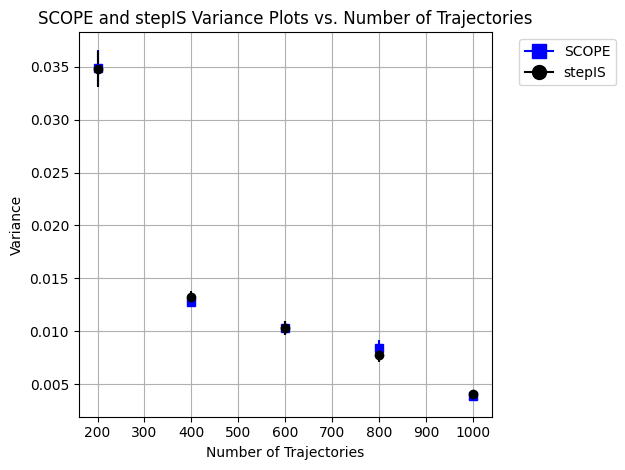

<Figure size 640x480 with 0 Axes>

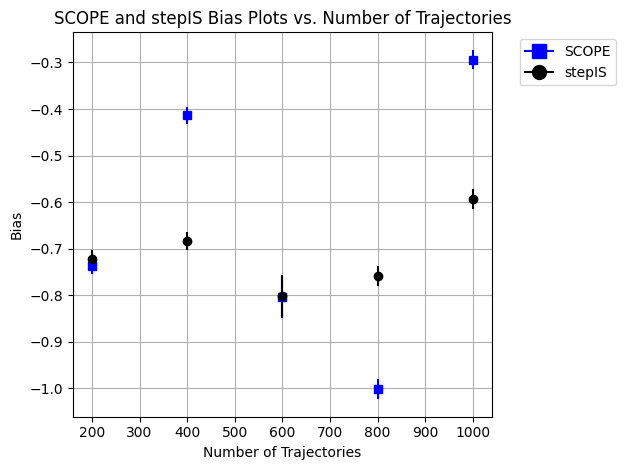

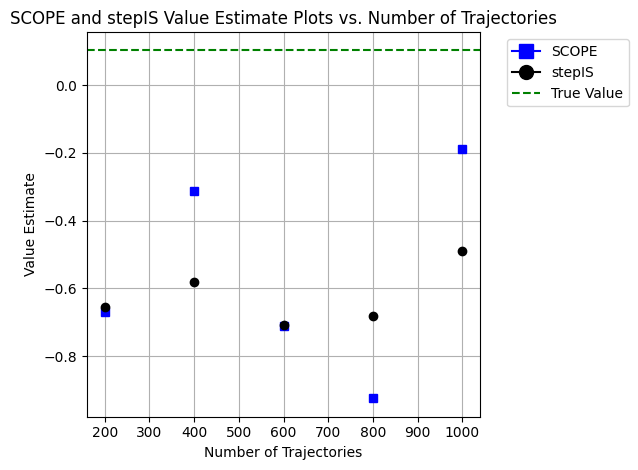

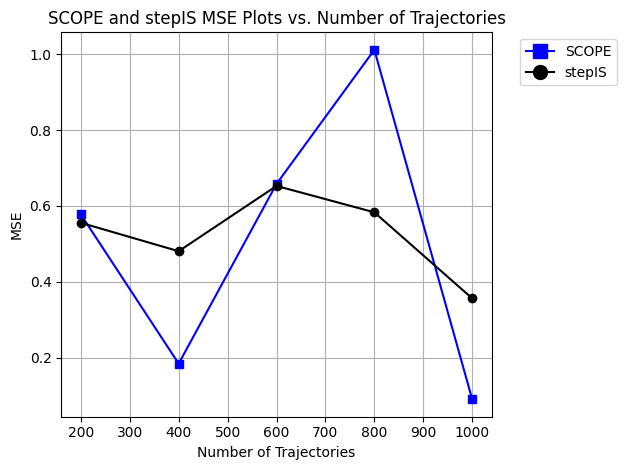

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(2, 2)], [], 1, -2,3, 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
# for i in num_trajectories:
#   print('num_trajectories: ', i)
#   modify_data(env, i, behav_policy, eval_policy, 0.3,0.0)
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

Number of trajectories:  200
Number of trajectories:  400
Number of trajectories:  600
Number of trajectories:  800
Number of trajectories:  1000
Trajectories:  200
True Val:  [0.16931370422774206, 0.19484597057782974, 0.17884308419864003, 0.2186056336741843, 0.19507629884676006]
SCOPE Results:  {'std_devs_list': [0.12434683315910512, 0.13625984400852936, 0.12703150882467149, 0.1322388768676745, 0.12841438519283768], 'mean_list': [0.06826067729315716, 0.0538635893377337, 0.07326584480030104, 0.0649809403912065, 0.072299423342123]}
IS Results:  {'std_devs_list': [0.13590906516615722, 0.1502602754569077, 0.13992800301275118, 0.14380835557760102, 0.1413774650179553], 'mean_list': [-0.45333398847017087, -0.46719029507451526, -0.446412275447978, -0.46013121918297534, -0.4488413527082574]}
mse_scope:  0.03240440151278271
Trajectories:  400
True Val:  [0.20206009067481182, 0.2086956846792515, 0.20517889473436618, 0.20511107061782655, 0.21221035694271953]
SCOPE Results:  {'std_devs_list': [0.1

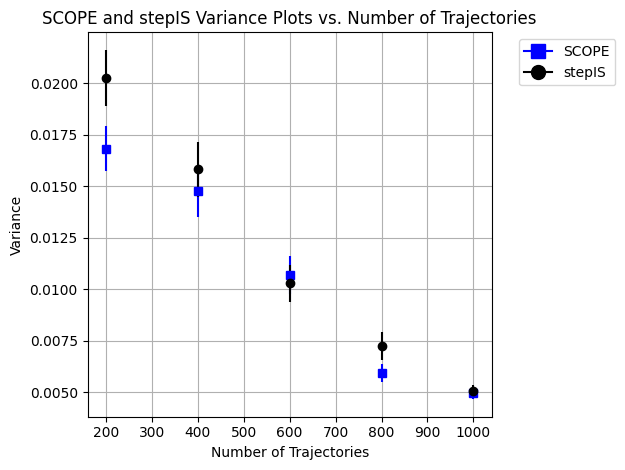

<Figure size 640x480 with 0 Axes>

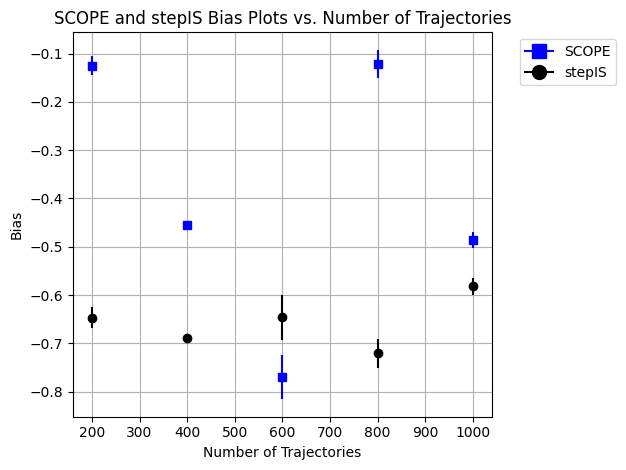

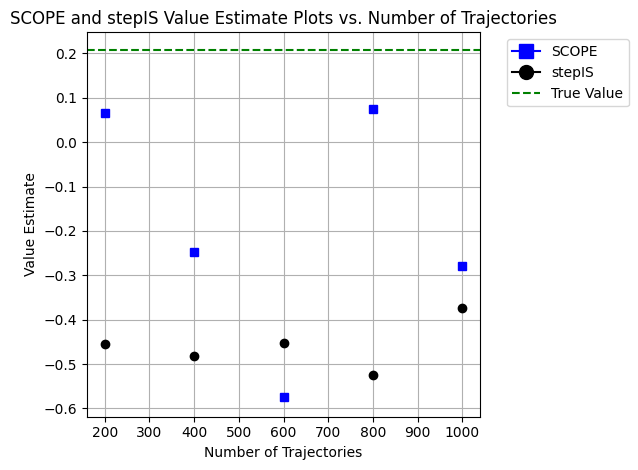

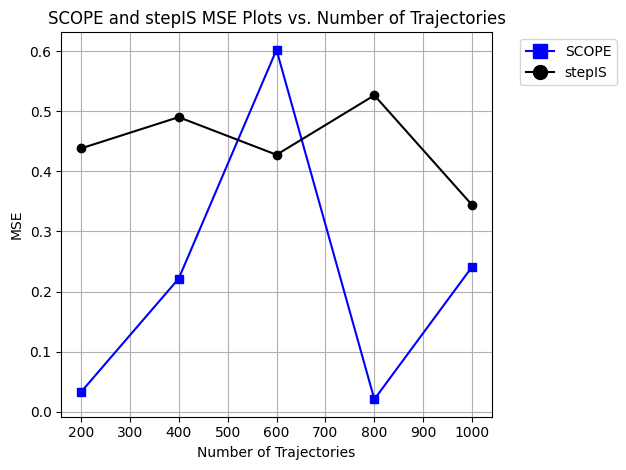

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(2, 3)], [], 1, -2,3, 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

Number of trajectories:  200
Number of trajectories:  400
Number of trajectories:  600
Number of trajectories:  800
Number of trajectories:  1000
Trajectories:  200
True Val:  [0.1635710089532547, 0.1123226136323559, 0.16885667454170808, 0.14344917406346314, 0.1498024208731246]
SCOPE Results:  {'std_devs_list': [0.2183870759117268, 0.22251179255865144, 0.21693648847544536, 0.2286799165447516, 0.21957121841879232], 'mean_list': [-0.47046880822194465, -0.45473779893598026, -0.47790357072208356, -0.48724023506469066, -0.46857791216236516]}
IS Results:  {'std_devs_list': [0.21832469495772272, 0.22244003543077115, 0.21684340430883475, 0.22861341593046594, 0.2194755443713152], 'mean_list': [-0.46570775729700026, -0.4499739250455176, -0.47315885117438183, -0.48243723448524506, -0.4638273592169369]}
mse_scope:  0.43259344619583007
Trajectories:  400
True Val:  [0.1687397664685641, 0.15952019870454257, 0.10342388903197855, 0.16550966268661083, 0.05712162418970858]
SCOPE Results:  {'std_devs_lis

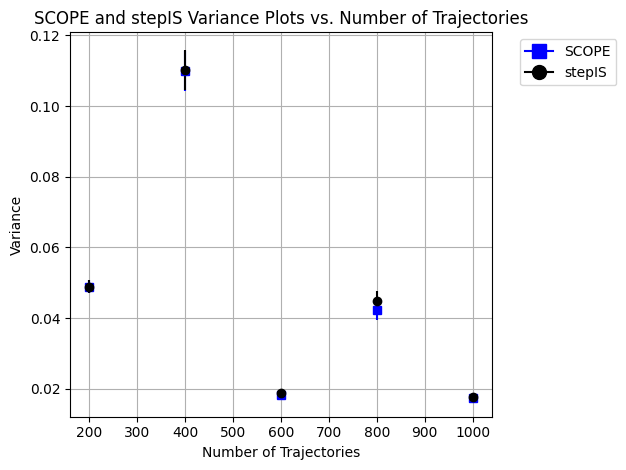

<Figure size 640x480 with 0 Axes>

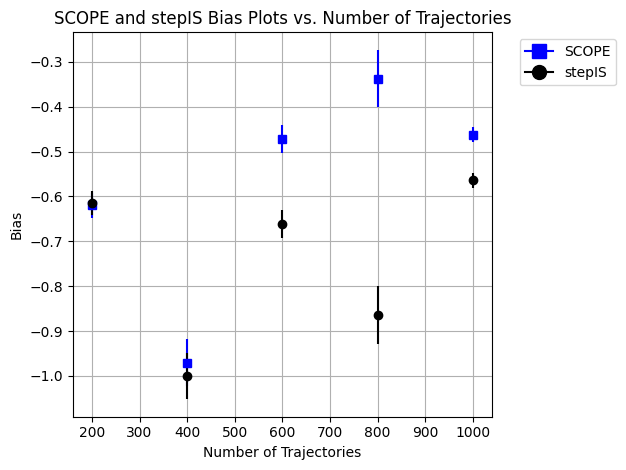

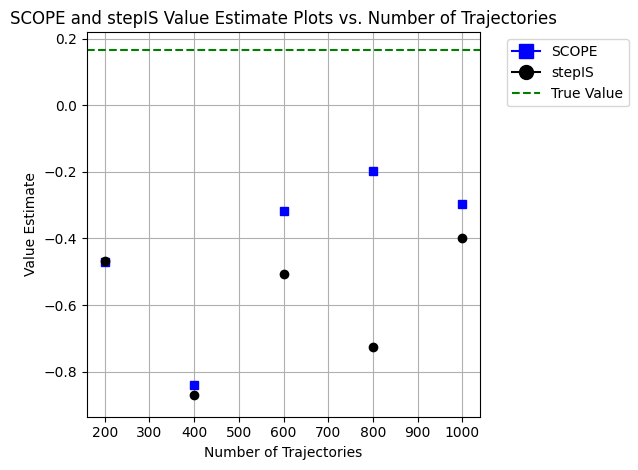

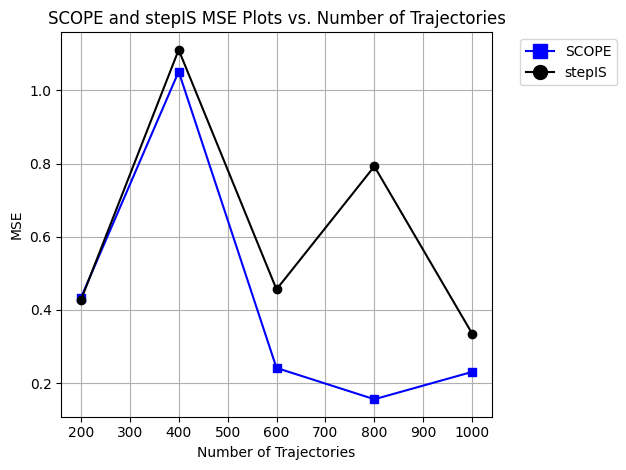

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(1, 4)], [], 1, -2,3, 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

Number of trajectories:  200
Iteration: 1
Beta: [-0.06442962]
Variance Scope: 0.01929206413508223
----------
Var SCOPE_phi:  0.027411036461177065
Var IS_phi:  0.03225735008331805
Percent change in variance:  -15.02390496932749
SCOPE results:  {'std_devs_list': [0.16761949454911, 0.1598020520110471, 0.16657546034176546, 0.1623723603708342, 0.16013667138571697], 'mean_list': [-0.003376596354533325, 0.0025220971008936507, -0.0010720467935712722, 0.00367854877568141, -0.002586273729727869]}
IS results:  {'std_devs_list': [0.17797191808589707, 0.16921147214761104, 0.17663211451005778, 0.17127451577024888, 0.17059478321193192], 'mean_list': [-0.42959252039446916, -0.4232386828345279, -0.42597812107259053, -0.42513744734866526, -0.4283612447062877]}
true eval:  0.0577108549152369
Number of trajectories:  400
Iteration: 1
Beta: [-0.08278146]
Variance Scope: 0.028359255860068766
----------
Var SCOPE_phi:  0.025698981285823562
Var IS_phi:  0.03473258936641957
Percent change in variance:  -26.009

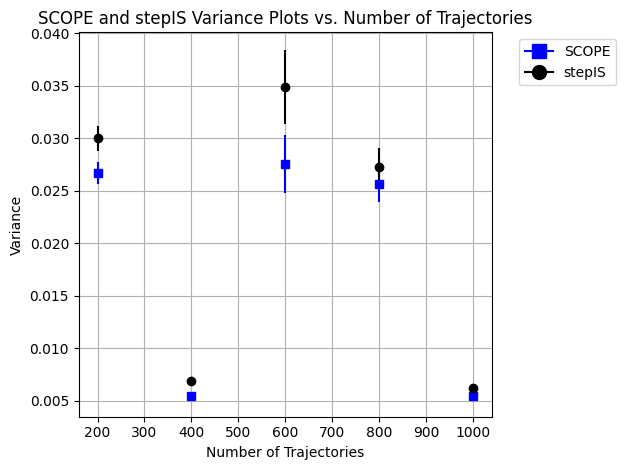

<Figure size 640x480 with 0 Axes>

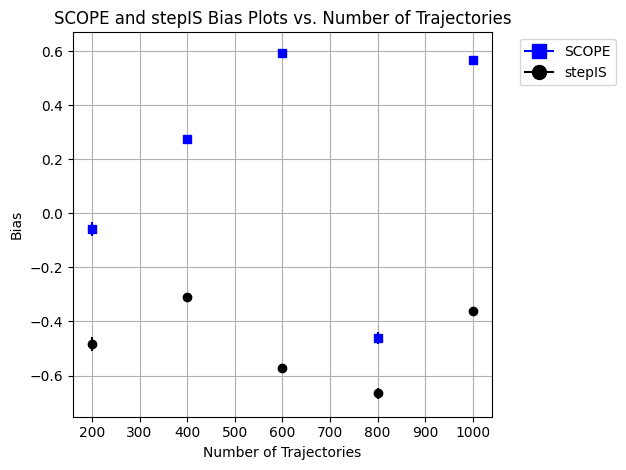

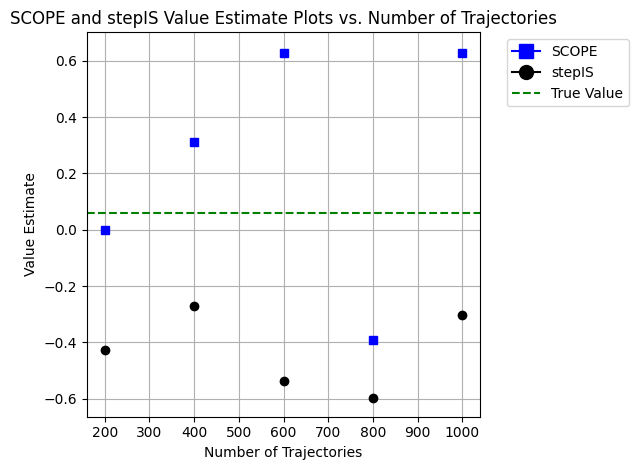

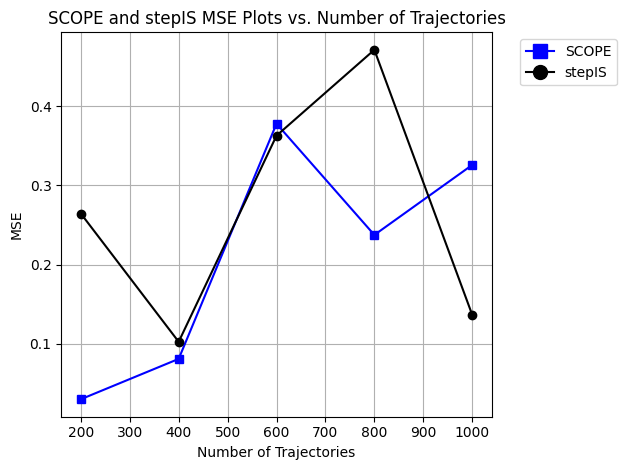

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(3, 4)], [], 1, -2,3, 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

In [ ]:
# np.random.seed(42)
# env = GridWorld(height, width, start, end, [(3, 4)], [], 1, -2,3, 0.0)
# eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
# behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
# num_trajectories = [200,400, 600, 800,1000]
# compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

Number of trajectories:  200
Iteration: 1
Beta: [-0.06442961]
Variance Scope: 0.019292064135082172
----------
Var SCOPE_phi:  0.027411036531058277
Var IS_phi:  0.03225735008331805
Percent change in variance:  -15.023904752690937
SCOPE results:  {'std_devs_list': [0.1676194954840704, 0.15980205275150666, 0.16657546123849476, 0.16237236108674533, 0.16013667229086223], 'mean_list': [-0.003376651078718953, 0.0025220424351464522, -0.0010721013495781637, 0.0036784937176583517, -0.0025863283972971354]}
IS results:  {'std_devs_list': [0.17797191808589707, 0.16921147214761104, 0.17663211451005778, 0.17127451577024888, 0.17059478321193192], 'mean_list': [-0.42959252039446916, -0.4232386828345279, -0.42597812107259053, -0.42513744734866526, -0.4283612447062877]}


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



true eval:  0.0577108549152369
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-126-a39c4359f786>", line 6, in <cell line: 6>
    compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )
  File "<ipython-input-33-713e4e28daf8>", line 4, in compare_experiments_over_trajectories
    run_experiment1(env,i ,behav_policy, eval_policy, phi_traj, sparsity)
  File "<ipython-input-109-079b0cc8b778>", line 36, in run_experiment1
    save_data_to_file(data_to_save, file)
  File "<ipython-input-12-ff2cc69832a4>", line 2, in save_data_to_file
    with open(filename, 'wb') as file:
OSError: [Errno 107] Transport endpoint is not connected: 'pi_b_0.25_0.25_0.25_0.25_pi_e_0.40_0.10_0.10_0.40__1_br_3_4_-2_trajectories_200_train_split_0.3_sparsity_0.0.txt'

During handling of the above exception, 

Number of trajectories:  200
Iteration: 1
Beta: [0.02427283]
Variance Scope: 0.0378761019254302
----------
Var SCOPE_phi:  0.032595846983779674
Var IS_phi:  0.033246187995963655
Percent change in variance:  -1.9561370833339995
SCOPE results:  {'std_devs_list': [0.17584008377474084, 0.17046345995498688, 0.16403174948988464, 0.17552245177252643, 0.17398048385499404], 'mean_list': [-0.5180127992517574, -0.5145402301825477, -0.5078096012124174, -0.5100260989112558, -0.5117582067990334]}
IS results:  {'std_devs_list': [0.17311694144285086, 0.1674552080573039, 0.1617117050688926, 0.1729805770568533, 0.17123428119610987], 'mean_list': [-0.4361346117409895, -0.4330571369049677, -0.4262166748769717, -0.42817163041017053, -0.42981479893845265]}
true eval:  0.23419224965579805
Number of trajectories:  400
Iteration: 1
Beta: [-0.01114329]
Variance Scope: 0.019317823075696523
----------
Var SCOPE_phi:  0.02042384665984882
Var IS_phi:  0.020792516255137422
Percent change in variance:  -1.77308792627

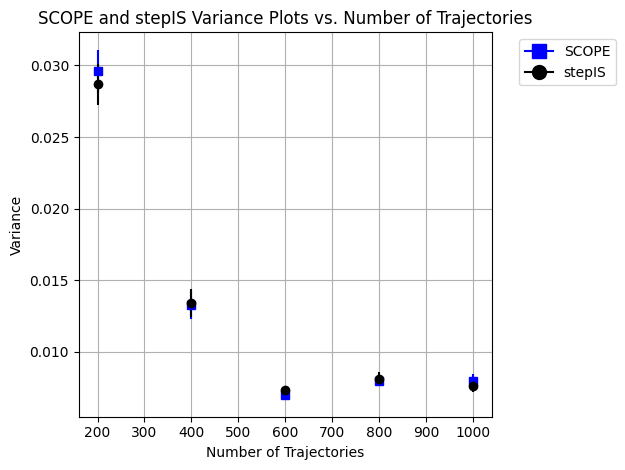

<Figure size 640x480 with 0 Axes>

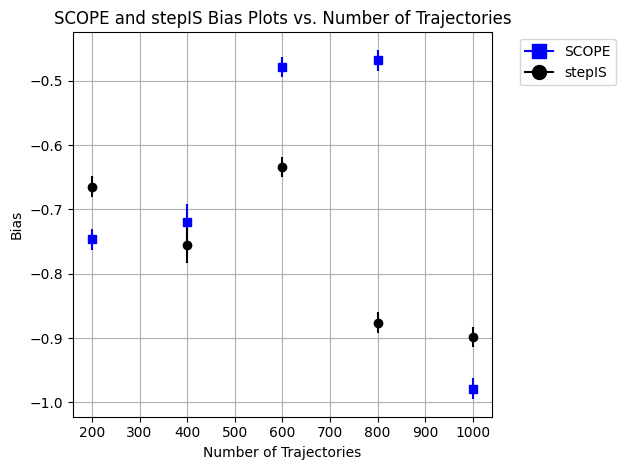

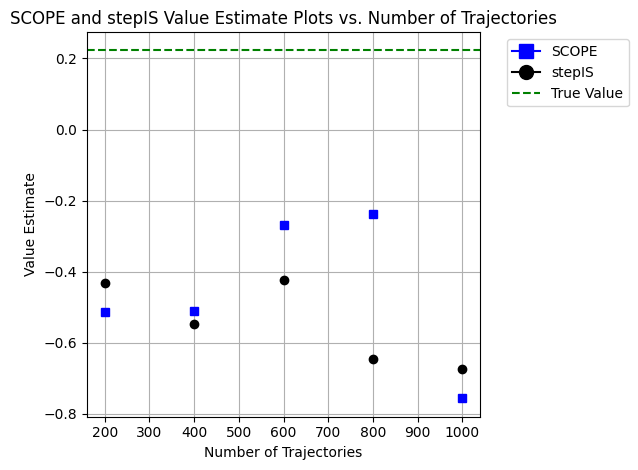

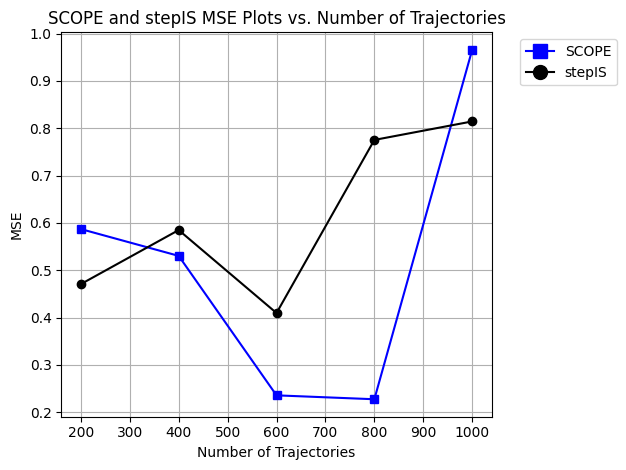

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(3, 1)], [], 1, -2,3, 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

Number of trajectories:  200
Iteration: 1
Beta: [-0.13148765]
Variance Scope: 0.1698123061207089
----------
Var SCOPE_phi:  0.16838657264136642
Var IS_phi:  0.17475572955101432
Percent change in variance:  -3.644605487906838
SCOPE results:  {'std_devs_list': [0.09800832467828276, 0.0967964674291793, 0.0948809761348145, 0.09607280199394733, 0.09774285666442274], 'mean_list': [0.31843986336437674, 0.3132064696650234, 0.3133867657134735, 0.31866068674015186, 0.3217594726849004]}
IS results:  {'std_devs_list': [0.10301363634420618, 0.10501611503338681, 0.09784190583525415, 0.10157570022185156, 0.10422960071053267], 'mean_list': [-0.415768069541887, -0.41833198680272154, -0.4168187173543747, -0.41744233558712174, -0.413153355782347]}
true eval:  0.015345591261291276
Number of trajectories:  400
Iteration: 1
Beta: [-0.00304533]
Variance Scope: 0.0466138176035723
----------
Var SCOPE_phi:  0.04648753176568461
Var IS_phi:  0.046625648040271084
Percent change in variance:  -0.2962238175589103
S

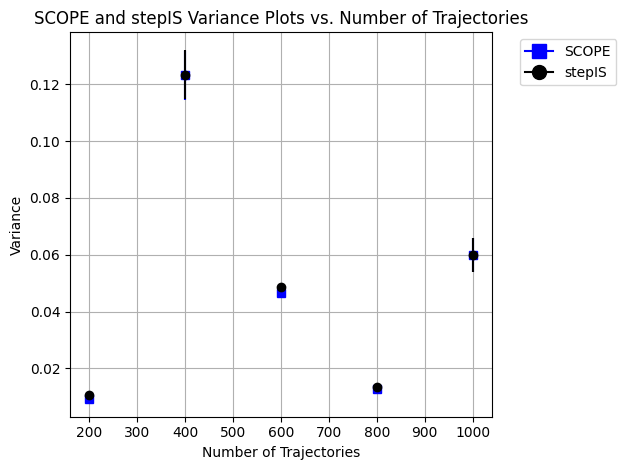

<Figure size 640x480 with 0 Axes>

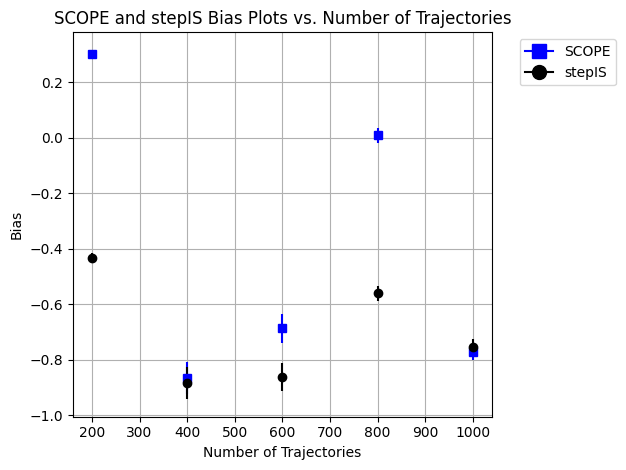

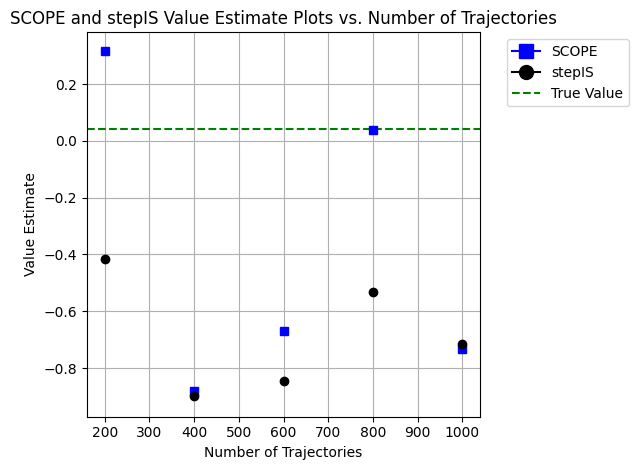

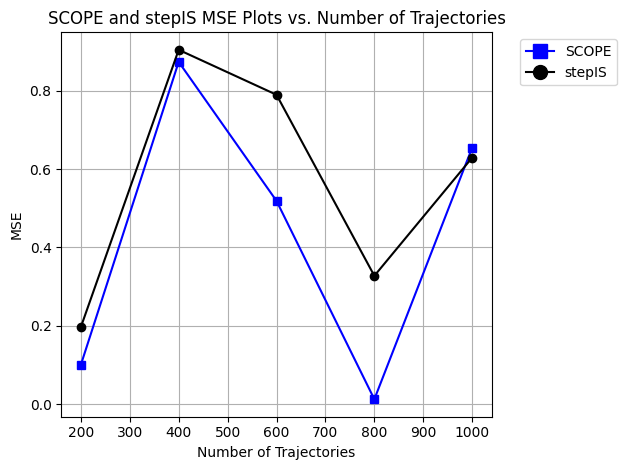

In [ ]:
np.random.seed(42)
env = GridWorld(height, width, start, end, [(4, 2)], [], 1, -2,3, 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

## Dense, 1 bad, similar

Number of trajectories:  200
Iteration: 1
Beta: [0.12591832]
Variance Scope: 0.09867972693126006
----------
Var SCOPE_phi:  0.11526168318462666
Var IS_phi:  0.1325219451023898
Percent change in variance:  -13.024455613315528
SCOPE results:  {'std_devs_list': [0.18631310099937268, 0.16901526076006906, 0.19031594191579676, 0.1704323533857024, 0.17171391101495107], 'mean_list': [1.2816124762732544, 1.288680265936118, 1.2770611855953773, 1.2817991844762482, 1.2774498084100185]}
IS results:  {'std_devs_list': [0.20503393048970228, 0.18833825827835787, 0.2110091903593298, 0.18810741167057712, 0.1919837749868039], 'mean_list': [1.7568650356889126, 1.763945909523111, 1.7521456489903822, 1.7555627181682936, 1.750083416528456]}
true eval:  2.6909825966767738
Number of trajectories:  400
Iteration: 1
Beta: [0.15191948]
Variance Scope: 0.06540878892837644
----------
Var SCOPE_phi:  0.06868774413284245
Var IS_phi:  0.06476208742589318
Percent change in variance:  6.061658700302671
SCOPE results:  {

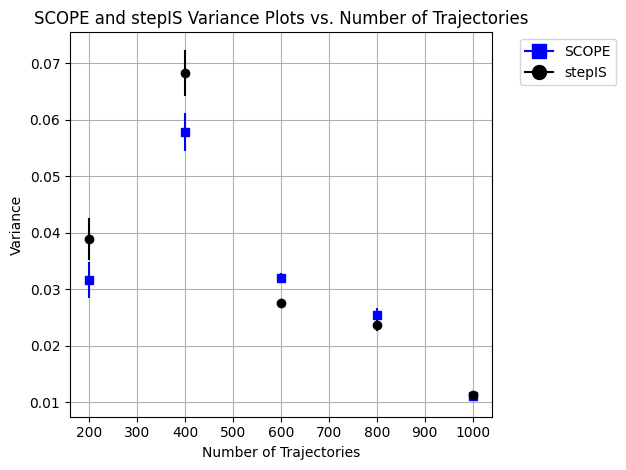

<Figure size 640x480 with 0 Axes>

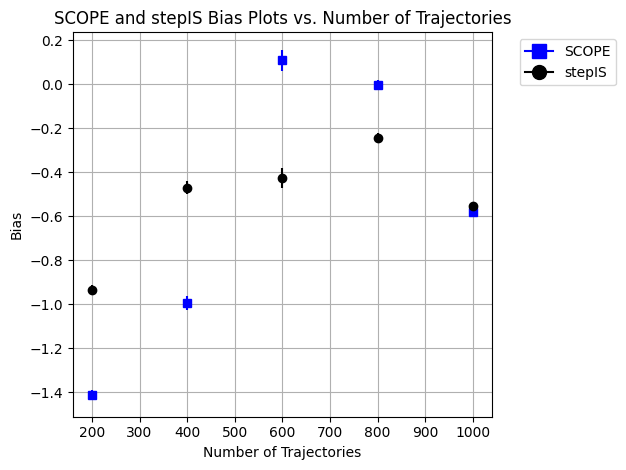

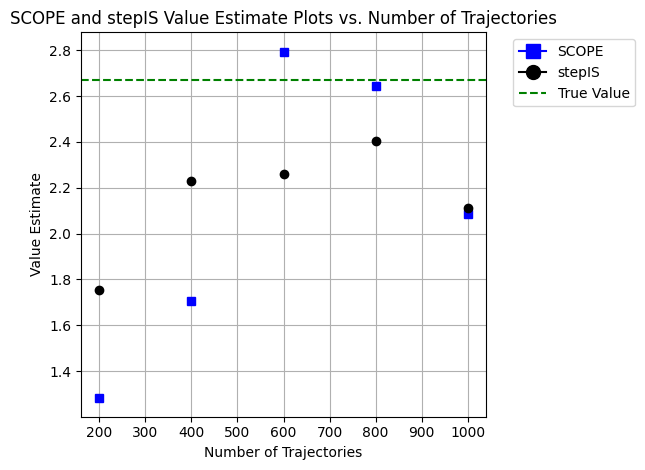

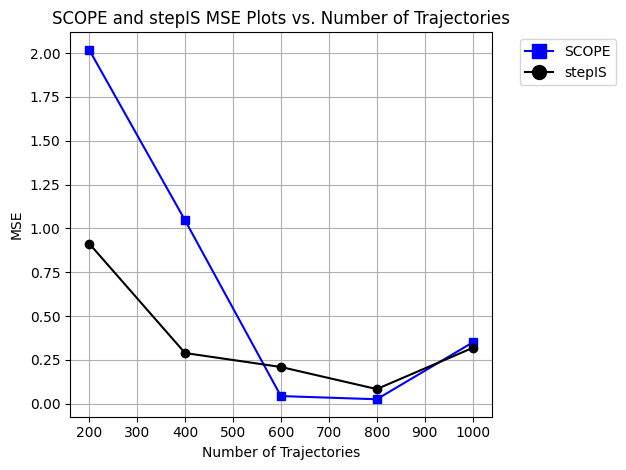

In [ ]:
env = GridWorld(height, width, start, end, [(2, 2)], [], 1, -2,3, 0.8)
eval_policy = {"up": 0.36, "down": 0.14, "left": 0.14, "right": 0.36}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
# for i in num_trajectories:
#   run_experiment(env,i ,behav_policy, eval_policy, 0.3, 0.8)
#   print(i," trajectories done")
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.8 )

In [ ]:
env = GridWorld(height, width, start, end, [(4, 2)], [], 1, -2,3, 0.8)
eval_policy = {"up": 0.36, "down": 0.14, "left": 0.14, "right": 0.36}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
# for i in num_trajectories:
#   run_experiment(env,i ,behav_policy, eval_policy, 0.3, 0.8)
#   print(i," trajectories done")
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.8 )

## Sparse, 1 bad, similar

Number of trajectories:  200
Iteration: 1
Beta: [-0.01628514]
Variance Scope: 0.012389324504627429
----------
Var SCOPE_phi:  0.01421119627679231
Var IS_phi:  0.014236972199308306
Percent change in variance:  -0.18104918767242267
SCOPE results:  {'std_deviation': 0.12413381992173188, 'quartiles': array([-0.60910863, -0.25290312, -0.17568307, -0.08564263,  0.28023038]), 'max_value': 0.28023038215550883, 'min_value': -0.609108631942183, 'mean': -0.1752576342476546}
IS results:  {'std_deviation': 0.12594179668418148, 'quartiles': array([-0.68858516, -0.33023583, -0.25382678, -0.16280926,  0.21167556]), 'max_value': 0.21167556399777512, 'min_value': -0.6885851623998253, 'mean': -0.25332444496611894}
true eval:  0.1315091517071818
Number of trajectories:  400
Iteration: 1
Beta: [0.07256854]
Variance Scope: 0.013164684027024611
----------
Var SCOPE_phi:  0.01281937310638122
Var IS_phi:  0.013873762528019987
Percent change in variance:  -7.5998808507013225
SCOPE results:  {'std_deviation': 0.

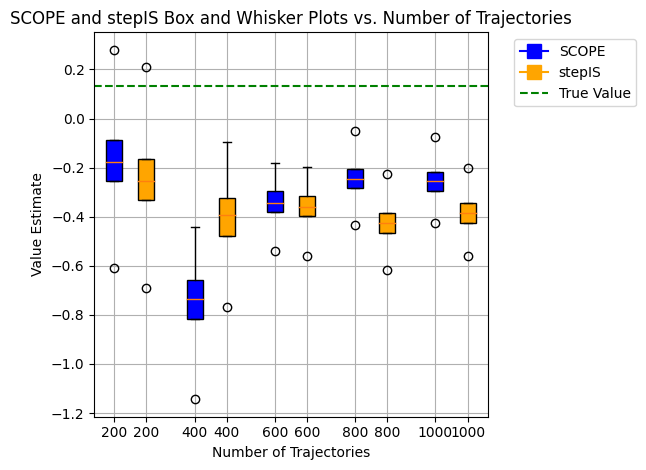

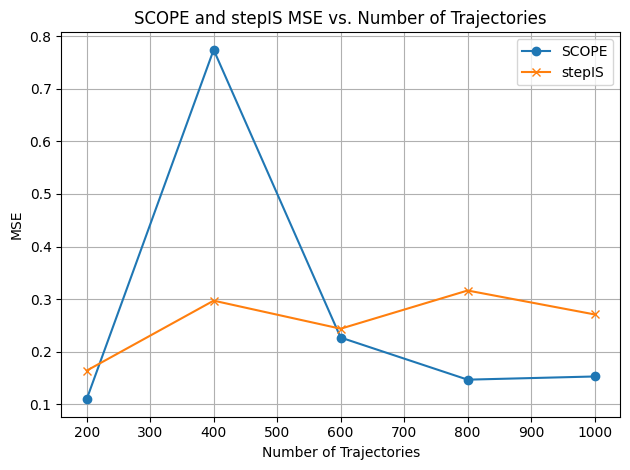

In [ ]:
env = GridWorld(height, width, start, end, [(2, 3)], [], 1, -2,3, 0.01)
eval_policy = {"up": 0.36, "down": 0.14, "left": 0.14, "right": 0.36}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
# for i in num_trajectories:
#   run_experiment(env,i ,behav_policy, eval_policy, 0.3, 0.01)
#   print(i," trajectories done")
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.01 )

# Fix

## Dense same policy

In [ ]:
env = GridWorld(height, width, start, end, [(2,3)], [], 1, -2,3, 0.8)
eval_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.8 )

In [ ]:
env = GridWorld(height, width, start, end, [(2,3)], [], 1, -2,3, 0.85)
eval_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.85 )

## Sparse same policy

In [ ]:
env = GridWorld(height, width, start, end, [(2,3)], [], 1, -2,3, 0.0)
eval_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

## Sparse 2 bad regions, same policy

In [ ]:
env = GridWorld(height, width, start, end, [(2,3),(3,4)], [], 1, -2,3, 0.0)
eval_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

In [ ]:
env = GridWorld(height, width, start, end, [(2,3),(3,4)], [], 1, -2,3, 0.1)
eval_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
# num_trajectories = [200,400, 600, 800,1000]
num_trajectories = [200,400]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

## Sparse one bad region, very similar policies

In [ ]:
env = GridWorld(height, width, start, end, [(2, 2)], [], 1, -2,3, 0.1)
eval_policy = {"up": 0.26, "down": 0.24, "left": 0.24, "right": 0.26}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
# num_trajectories = [200,400]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.1)

## Two bad regions

In [ ]:
env_bad = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [], 0.5, -2, 3 )
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]

In [ ]:
results = run_experiment(env_bad,200 ,behav_policy, eval_policy, 0.3)

In [ ]:
for i in num_trajectories:
  run_experiment(env_bad,i ,behav_policy, eval_policy, 0.3)
  print(i," trajectories done")

In [ ]:
plot_rewards_over_trajectories(env_bad, num_trajectories, behav_policy, eval_policy, 0.3)

## Single bad region

In [ ]:
num_trajectories = [200, 400, 600, 800, 1000]

In [ ]:
env_bad_one = GridWorld(height, width, start, end, [(2, 2)], [], 0.5, -2, 3 )
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}

In [ ]:
for i in num_trajectories:
  run_experiment(env_bad_one,i ,behav_policy, eval_policy, 0.3)
  print(i," trajectories done")

In [ ]:
plot_rewards_over_trajectories(env_bad_one, num_trajectories ,behav_policy, eval_policy, 0.3)

In [ ]:
evaluation_policies = create_policy_set(env_bad_one, run_policy,eval_policy, 1000)
true_evaluation = print("True Eval: ",calc_V_pi_e(evaluation_policies))

## Two bad regions One good region

In [ ]:
env_2bad_1good = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [(3,3)], 0.5, -2, 3 )
eval_policy = {"up": 0.36, "down": 0.14, "left": 0.14, "right": 0.36}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}

In [ ]:
run_experiment(env_2bad_1good,200, behav_policy, eval_policy, 0.3)

In [ ]:
num_trajectories = [200, 400, 600, 800, 1000]

In [ ]:
for i in num_trajectories:
  run_experiment(env_2bad_1good,i ,behav_policy, eval_policy, 0.3)
  print(i," trajectories done")

In [ ]:
plot_rewards_over_trajectories(env_2bad_1good, num_trajectories, behav_policy, eval_policy, 0.3)

In [ ]:
evaluation_policies = create_policy_set(env_2bad_1good, run_policy,eval_policy, 1000)
true_evaluation = print("True Eval: ",calc_V_pi_e(evaluation_policies))

## Two bad regions One good region similar policies

In [ ]:
env_2bad_1good_similar = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [(3,3)], 0.5, -2, 3 )
behav_policy = {"up": 0.36, "down": 0.14, "left": 0.14, "right": 0.36}
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}

In [ ]:
for i in num_trajectories:
  run_experiment(env_2bad_1good_similar,i ,behav_policy, eval_policy, 0.3)
  print(i," trajectories done")

In [ ]:
plot_rewards_over_trajectories(env_2bad_1good_similar, num_trajectories, behav_policy, eval_policy, 0.3)